<a href="https://colab.research.google.com/github/vgeneva/NN_Backprop/blob/main/iterOCK_take2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np
# numpy has a random number generator and some
# sampling functionality which we can seed with
# a fixed number to get consistent run results
np.random.seed();
from matplotlib import pyplot as plt
import pandas as pd
from numpy import linalg as LA
from scipy.integrate import solve_ivp  # solve ODE
from matplotlib.animation import PillowWriter    # writing the .gif
import time
import tensorflow as tf
import random

# Make x\_input.

In [2]:
## starting trajectory

a = .3
b = .7
h_x = ((b-a))/100
print(b-a)
print(h_x)
k_x = round((b-a)/h_x) #int makes it round down. round, lets it round
print(k_x)
x_input = np.reshape(np.arange(a, b + h_x, step = h_x), (k_x+1, 1))
print(x_input.shape)
df_x_input = pd.DataFrame(x_input)
df_x_input.describe()

0.39999999999999997
0.004
100
(101, 1)


,0
count,101.000000
mean,0.500000
std,0.117201
min,0.300000
25%,0.400000
50%,0.500000
75%,0.600000
max,0.700000


# Kernel Functions

In [3]:
# A collection of vectorized kernel functions
# x, and y are assumed to be Matrices
# if you want to evaluate on a single point
# reshape the vectors from d to d x 1, this
# will turn them into matrices. All the kernel
# functions work with vectors or matrices with the
# exception of k5v which requires matrices as inputs.

# Linear kernel, notice, if x, and y
# are vectors, this will return a scalar
# if x, and y are matrices, this will
# return a matrix and this is an efficient
# and vectorized implementation of the linear
# kernel function.
def k1v(x,y):
    # np.dot computes the vector dot
    # product if x, and y are vectors
    # or it computes the matrix product
    # of x and y, if x or y are matrices
    return (np.dot(x,y.T))

# Affine kernel. Again, if x and y are
# vectors, this will return a scalar but
# if x, and y are matrices this is a vectorized
# version of the affine kernel.
def k2v(x,y):
    return (np.dot(x,y.T)+1)

# Quadratic kernel. Again, if x and y are
# vectors, this will return a scalar but
# if x, and y are matrices this is a vectorized
# version of the Quadratic kernel.
def k3v(x,y):
    # To raise a number by a power python
    # uses ** instead of ^, ^ is reserved
    # for bit operations. (and?)
    return ((1+np.dot(x,y.T))**2)

# dth order kernel, (here d=4)
d = 4
def k4v(x,y):
    return ((1+np.dot(x,y.T))**d)

# Gaussian kernel. This is the only kernel function
# in this set of example kernels that is tricky to
# efficiently vectorize. This is because to evaluate
# this kernel function, we have to evaluate (x-y)^T(x-y)
# whereas in all the other examples, we evaluate x^Ty
# Expanding (x-y)^T(x-y) gives us x^Tx - 2x^Ty + y^Ty
# So k(x_i,y_j) = e^(-(x_i-y_j)^T(x_i-y_j)/(2*sigma^2))
# So k(x_i,x_j) = f(x_i^Tx_i+y_j^Ty_j-2x_i^Ty_j)
# we get x_i^Ty_j using np.dot(X,Y) where X and Y are the
# X and Y data matrices respectively. We get x_i^Tx_i using
# np.sum(X*X,axis=1).reshape(d,1). This function requires
# matrices and will fail if x, or y are vectors. It is
# vectorized and efficient. For any kernel function that uses
# k(x_i,x_j) = f((x_i-x_j)^T(x_i-x_j)) use the line that
# computes XminusYSquared to compute the matrix whose i,jth
# entry is (x_i-x_j)^T(x_i-x_j) in a vectorized and efficient
# manner. Then apply f(XminusYsquared).

# sigma can be picked for the specific problem at hand
sigma = 2**0;
def k5v(x,y):
    numxPoints = np.shape(x)[0];
    numyPoints = np.shape(y)[0];
    XminusYSquared =np.sum(x*x,axis=1).reshape([numxPoints,1])-2*np.dot(x,y.T)+np.sum(y*y,axis=1).reshape([1,numyPoints]);
    return np.exp(-XminusYSquared/(2*sigma**2))


def gauss_0(x,y): # zero boundary conditions
    numxPoints = np.shape(x)[0];
    numyPoints = np.shape(y)[0];
    XminusYSquared =np.sum(x*x,axis=1).reshape([numxPoints,1])-2*np.dot(x,y.T)+np.sum(y*y,axis=1).reshape([1,numyPoints]);
    return np.exp(-XminusYSquared/(2*sigma**2))

# Hyperbolic tangent vectorized kernel function
kappa=1
theta=1
def k6v(x,y):
    return (np.tanh(kappa*np.dot(x,y.T)+theta));

def k7v(x,y):
    return np.exp(-1/(2*sigma**2) * (x-y)**2)
# Set the kernel function to be whatever we choose
# in this case the gaussian kernel

def k10v(x,y):
  return x*y

k = k5v;

In [4]:
k10v(x_input,x_input)[0:10,:]

array([[0.09    ],
       [0.092416],
       [0.094864],
       [0.097344],
       [0.099856],
       [0.1024  ],
       [0.104976],
       [0.107584],
       [0.110224],
       [0.112896]])

In [5]:
x_input

array([[0.3  ],
       [0.304],
       [0.308],
       [0.312],
       [0.316],
       [0.32 ],
       [0.324],
       [0.328],
       [0.332],
       [0.336],
       [0.34 ],
       [0.344],
       [0.348],
       [0.352],
       [0.356],
       [0.36 ],
       [0.364],
       [0.368],
       [0.372],
       [0.376],
       [0.38 ],
       [0.384],
       [0.388],
       [0.392],
       [0.396],
       [0.4  ],
       [0.404],
       [0.408],
       [0.412],
       [0.416],
       [0.42 ],
       [0.424],
       [0.428],
       [0.432],
       [0.436],
       [0.44 ],
       [0.444],
       [0.448],
       [0.452],
       [0.456],
       [0.46 ],
       [0.464],
       [0.468],
       [0.472],
       [0.476],
       [0.48 ],
       [0.484],
       [0.488],
       [0.492],
       [0.496],
       [0.5  ],
       [0.504],
       [0.508],
       [0.512],
       [0.516],
       [0.52 ],
       [0.524],
       [0.528],
       [0.532],
       [0.536],
       [0.54 ],
       [0.544],
       [

## Variables for Random Fouirer Features

In [6]:
num_features = 1000

In [7]:
feature_coeff = 1 / np.sqrt(num_features)

## Z's for guassian random Fourier features, alpha, and new_alpha all have the same Z's.

### Z's for guassian kernel, alpha, and alpha_new

In [8]:
# creating fourier samples (create a vector of random numbers to be the scale inputs, which are x)
# in the feature_map, we have cosines and sines and we have num_features cosines, so that means we will need
# num_features sines for the fourier features. Our input then is num_features, but our vector col will be
# 2 * num_features_alpha.

# we need to make our standard deviation 1/sqrt(\sigma^2). Here , when i selet
# fourier, sample, its with sigma = 1, so this is 1\sqrt (1).

#fourier_sample_alpha = np.random.normal(size = (num_features_alpha,1))  #these are the randomly picked z's for the fourier-features
fourier_sample = np.random.normal(scale = 1, size = (num_features,1))


#fourier_sample_alpha  = np.reshape(np.linspace(-3, 3, num_features_alpha), (num_features_alpha,1))
fourier_sample = tf.constant(fourier_sample)


print(np.std(fourier_sample))

1.03915925540162


### Z's for alpha

In [9]:
# creating fourier samples (create a vector of random numbers to be the scale inputs, which are x)
# in the feature_map, we have cosines and sines and we have num_features cosines, so that means we will need
# num_features sines for the fourier features. Our input then is num_features, but our vector col will be
# 2 * num_features_alpha.

# we need to make our standard deviation 1/sqrt(\sigma^2). Here , when i selet
# fourier, sample, its with sigma = 1, so this is 1\sqrt (1).

#fourier_sample_alpha = np.random.normal(size = (num_features_alpha,1))  #these are the randomly picked z's for the fourier-features
#fourier_sample_alpha = np.random.normal(scale = 1, size = (num_features,1))


#fourier_sample_alpha  = np.reshape(np.linspace(-3, 3, num_features_alpha), (num_features_alpha,1))
#fourier_sample_alpha = tf.constant(fourier_sample_alpha)


#print(np.std(fourier_sample_alpha))

### Z's for phi_0

In [10]:
fourier_sample_phi0 = np.random.normal(scale = 1, size = (num_features,1))


#fourier_sample_alpha  = np.reshape(np.linspace(-3, 3, num_features_alpha), (num_features_alpha,1))
fourier_sample_phi0 = tf.constant(fourier_sample_phi0)


print(np.std(fourier_sample_phi0))

0.9751218285388324


### Theta for phi_0

In [11]:
# creating theta1 for phi_0
# scale these thetas to be scaled similarly to the fourier random features
#theta1 = np.random.normal(scale = 10 / np.sqrt(num_features),size = (2 * num_features, 1))
theta1 = np.random.normal(scale = 100 / np.sqrt(num_features),size = (2 * num_features, 1)) /10
theta1 = tf.constant(theta1)

### Thetas for alpha

In [12]:
# creating theta2 for alpha, note that i subtracted 2 from 2*num_features since
# we go down 2 dimensions
#theta2 = np.random.normal(scale = 1.0, size = ((2 * num_features_alpha)-2, 1))
theta2 = np.random.normal(scale = 2 / np.sqrt(num_features), size = ((2 * num_features)-2, 1))
#theta2 = np.random.normal(scale = 10, size = ((2 * num_features_alpha)-2, 1)) /20
theta2 = tf.constant(theta2)

# using guass kernel, so no need to increase dimenson
theta2_gauss = np.random.normal(scale = 10 / np.sqrt(num_features), size = ((2 * num_features), 1)) /20
theta2_gauss = tf.constant(theta2_gauss)

## Random Fourier Features

First we leverage Michael's code to create a fourier features map we denote as $\psi(x)$. Our inputs for this function are: an $x$ value, fourier_sample (which are scaling the inputs into the $\sin$ and $\cos$ components of the vector), and a feature coefficient which in our case is $1 / \sqrt{\text{number of features}}$. \begin{align}
    \psi(x) = \frac{1}{\sqrt{2p}} \begin{bmatrix}
        \cos(z_1x) \\
        \vdots\\
        \cos(z_{p/2}x)\\
        \sin(z_1x)\\
        \vdots\\
        \sin(z_{p/2}x)
    \end{bmatrix}
\end{align}

In [13]:
#feature map: Computes a feature map for a Gaussian kernel Fourier features approximation.
#Input:
#x - (n,d) matrix of n d-vectors to perform feature map on
#fourier_sample - (d,p) matrix of p samples from a d-dimensional standard normal distribution
#feature_coeff - 1/sqrt(p).  This could be computed from fourier_sample.
#Output:
#M - (2p+1,n) matrix of n feature vectors
#The +1 comes from the fact that this feature vector incorporates a constant term
# in regards to bandwidth, we are sampling from a normal distribution but using the guassian kernel.
# so we need to make our standard deviation 1/sqrt(\sigma^2). Here , when i selet
# fourier, sample, its with sigma = 1, so this is 1\sqrt (1).
def feature_map(x,fourier_sample,feature_coeff,bandwidth = .1):  #oritingal 0.1#bandwith is the sigma

    x = tf.transpose(x) #make x into a tensor for this calc
    fourierx = tf.linalg.matmul(fourier_sample,x)
    cos_fourierx = feature_coeff*tf.cos(fourierx/bandwidth)
    sin_fourierx = feature_coeff*tf.sin(fourierx/bandwidth)
    M = tf.concat([cos_fourierx,sin_fourierx],axis=0)

    return M

### Guassian Random Fourier Features, $k(x,y) = \psi(x)^T\psi(x)$

In [14]:
# normal guassian
def k9v(x,y,
        fourier_sample = fourier_sample,
        feature_coeff = feature_coeff,
        feature_map = feature_map):

    return tf.linalg.matmul(tf.transpose(feature_map(x, fourier_sample, feature_coeff))
                                                       , feature_map(y, fourier_sample
                                                       , feature_coeff))

### Testing k9v: Gaussian Random Fourier Features

In [15]:
#kernel_test_7 = tf.linalg.matmul(tf.transpose(feature_map(x_input, fourier_sample_alpha, feature_coeff)),feature_map(sol_alpha.y[:,1:2], fourier_sample_alpha, feature_coeff))
#print(kernel_test_7.shape)
#print(np.linalg.cond(kernel_test_7))

(101, 101)


4.650169756628047e+18

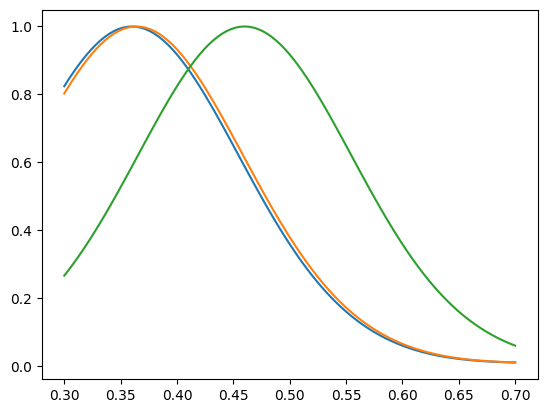

In [16]:
kern_gaus_test = k9v(x_input,x_input, fourier_sample, feature_coeff, feature_map)
plt.plot(x_input,kern_gaus_test[15,:]);
plt.plot(x_input,kern_gaus_test[16,:]);
plt.plot(x_input,kern_gaus_test[40,:]);
print(kern_gaus_test.shape)
np.linalg.cond(kern_gaus_test)

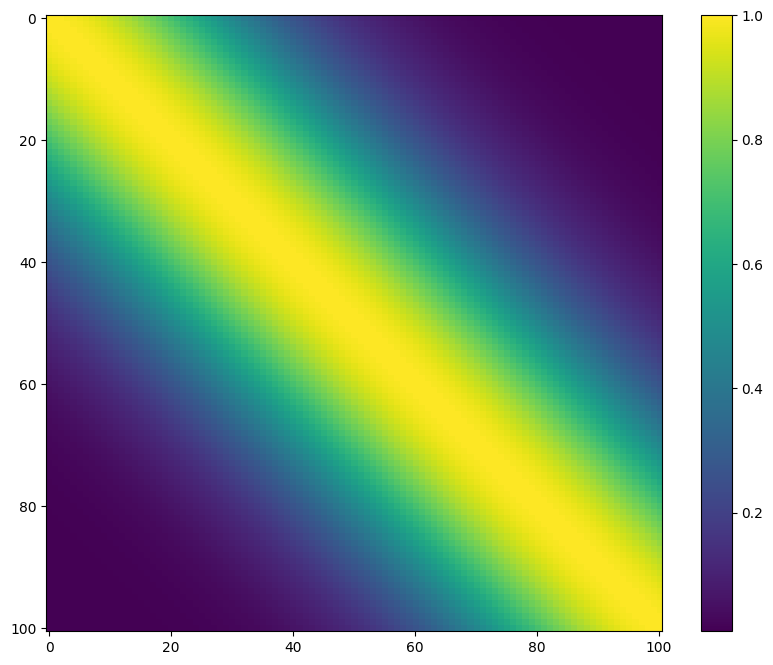

In [17]:
plt.figure(figsize = (10,8))
plt.imshow(kern_gaus_test);
plt.colorbar();

## Now create projection kernel function for $\psi_0(x) = \Lambda^{1/2} U^T \psi(x)$, $k_0(x,y) = \psi_0(x)^T \psi_0(y)$.

This is the explicit kernel function, but with ensuring we start and end at the same place as phi_0 and phi_1.

Using $k_0(x,y) = \psi(x)^T A \psi(y)$

When we generated our $\alpha$ function, we ensured that the $\alpha(0) = \alpha(1) = 0$.  We did this by following Dr. Bruno's notes on A RKHS constrained to functions verifying $\alpha(0) = 0$ and $\alpha(1) = 0$. We first start by considering an explicit kernel with random fourier features: $k(x,y)  = \psi(x)^T \psi(y)$

In [18]:
def g(x, y, fourier_sample = fourier_sample, feature_coeff = feature_coeff):
  return tf.linalg.matmul(tf.transpose(feature_map(x, fourier_sample, feature_coeff)),
                          feature_map(y, fourier_sample, feature_coeff))

:First make tensor flow arrays for $x_1 = [1], x_0 =[0], x_{01} =[0 ,1 ]$.

In [19]:
x_01 = np.array([0.,1.])
# reshape x_1 into a column vector
x_01 = np.reshape(x_01, (len(x_01),1))
# make numpy array into a tensorflow array
x_01 = tf.constant(x_01)

In [20]:
x_0 = np.array([0.])
x_0 = np.reshape(x_0, (len(x_0),1))
# make numpy array into a tensorflow array
x_0 = tf.constant(x_0)

In [21]:
x_1 = np.array([1.])
x_1 = np.reshape(x_1, (len(x_1),1))
# make numpy array into a tensorflow array
x_1 = tf.constant(x_1)

Now, let's create a gram matrix with our end points, $x = [0,1]$. Here we make  
G =\begin{bmatrix} k(0,0) & k(0,1) \\
                      k(0,1) & k(1,1)
      \end{bmatrix}

In [22]:
G = g(x_01,x_01)
print(G)
G_inv = tf.linalg.inv(G)
print(G_inv)

tf.Tensor(
[[ 1.         -0.00468845]
 [-0.00468845  1.        ]], shape=(2, 2), dtype=float64)
tf.Tensor(
[[1.00002198 0.00468855]
 [0.00468855 1.00002198]], shape=(2, 2), dtype=float64)


$(\psi(0),\psi(1))$, with $\psi(0), \psi(1) \in \mathbb{R}^p$.

In [23]:
p_0p_1 = feature_map(x_01, fourier_sample = fourier_sample, feature_coeff = feature_coeff)
print(p_0p_1.shape)

(2000, 2)


$(\psi(0), \psi(1)) G^{-1} (\psi(0), \psi(1))^T$

In [24]:
pGp = tf.linalg.matmul(tf.linalg.matmul(p_0p_1, G_inv), tf.transpose(p_0p_1))
print(pGp.dtype)
print(pGp.shape)

<dtype: 'float64'>
(2000, 2000)


In [25]:
I = tf.eye(2 * num_features, dtype=tf.float64)

$A = I - (\psi(0), \psi(1)) G^{-1} (\psi(0), \psi(1))^T$

In [26]:
A_g = tf.subtract(I,pGp)
print(A_g.shape)
#print(A_g)

(2000, 2000)


In [27]:
# A Hermitian matrix is a square matrix that is equal to its own complex conjugate transpose.
if np.allclose(A_g, np.conj(A_g).T):
    print("A is Hermitian")
else:
    print("A is not Hermitian")

A is Hermitian


In [28]:
# Use eigh
eig, U = LA.eigh(A_g)

In [29]:
# Define the condition for removing small values from
# eigenvalues. These are basically zero
condition = eig < 1e-14

# Use boolean indexing to select the elements that satisfy the condition
# this is telling me what meets the condition
remove = tf.boolean_mask(eig, condition)
# Obtain indexes where this condition is met
ind_to_remove = np.where(condition)

# new eig vector with no zeros
new_eig = np.delete(eig, ind_to_remove)
#new_eig = np.where(condition, eig, 0)

# new U matrix removing the eigenvectors corresponding to
# eigenvalues that were removed
new_U = np.delete(U, ind_to_remove, axis=1)


print(remove)
print(ind_to_remove)
print(new_eig)
print(new_eig.shape)
print(new_U.shape)
print(new_U[:,0].shape)

tf.Tensor([-3.64912065e-16  9.20023577e-16], shape=(2,), dtype=float64)
(array([0, 1]),)
[1. 1. 1. ... 1. 1. 1.]
(1998,)
(2000, 1998)
(2000,)


In [30]:
new_L = tf.linalg.diag(tf.sqrt(new_eig))
print(new_L.shape)

(1998, 1998)


$Λ^{1/2} U^T$ will be the same, so I don't need to recalculate every time we go through the equation.

In [31]:
LU = tf.linalg.matmul(new_L, tf.transpose(new_U))
print(LU.shape)

(1998, 2000)


In [32]:
np.linalg.cond(LU)

1.0000000000000042

$\psi_0(x) = Λ^{1/2}U^T \psi(x)$

In [33]:
# new feature map to make alpha and learning alpha
def feature_map_0(x, Lambda_unitary, fourier_sample = fourier_sample,
                  feature_coeff = feature_coeff, feature_map = feature_map, bandwidth = .1):
  #print(x.shape)
  p = feature_map(x, fourier_sample, feature_coeff, bandwidth)
  return tf.linalg.matmul(Lambda_unitary, p)

(1998, 1)
(1998, 1)


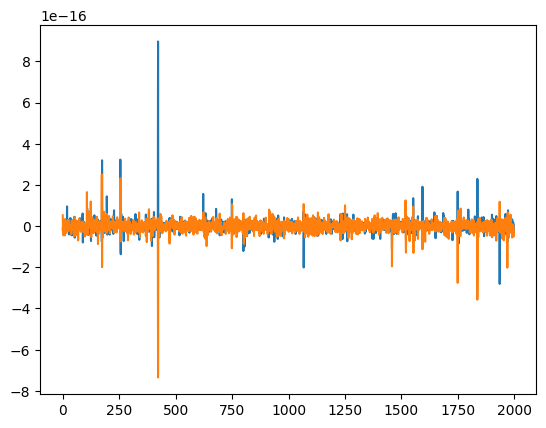

In [34]:
# An input of 1 dimensional vector should be (p-2,1)
# this graphs should show that psi_0(0) ≈ 0, psi_0(1) ≈ 0
f_0 = feature_map_0(x_0, LU)
print(f_0.shape) #length of fourier_features - 2 dimentison, x's with all cos's sine's
f_1 = feature_map_0(x_1, LU)
print(f_1.shape)
plt.plot(f_0);
plt.plot(f_1);#

### New kernel function for $\psi_0(x) = \Lambda^{1/2} U^T \psi(x)$ such that $k_0(x,y) = \psi_0(x)^T \psi_0(y)$.

This is the explicit kernel function, but with ensuring we start and end at the same place as phi_0 and phi_1.

In [35]:
# Remeber, LU will be fixed the entire time, will not change since it is about
# psi(x) at the boundaries only.
def k8v(x,y, Lambda_unitary = LU, fourier_sample = fourier_sample,
                  feature_coeff = feature_coeff, feature_map = feature_map):

    return tf.linalg.matmul(tf.transpose(feature_map_0(x, Lambda_unitary, fourier_sample
                                                       , feature_coeff, feature_map))
                                                       , feature_map_0(y, Lambda_unitary, fourier_sample
                                                       , feature_coeff, feature_map))

In [36]:
k8v(x_input,x_input).shape

TensorShape([101, 101])

### Testing Z's with projection kernel.

In [37]:
#ker_test_6 = k8v(x_input,sol_alpha.y[:,1:2])
#print(ker_test_6.shape)
#print(np.linalg.cond(ker_test_6))

In [38]:
x_05 = np.array([0.5])
# reshape x_1 into a column vector
x_05 = np.reshape(x_05, (len(x_05),1))
#print(x_01.shape)
# make numpy array into a tensorflow array
x_05 = tf.constant(x_05)

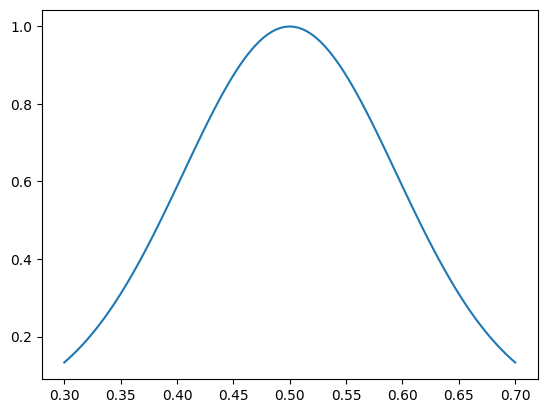

In [39]:
k8v(x_input, x_05)
plt.plot(x_input,k8v(x_input, x_05));

# Time intervals for my ODE integrator.
This is for my intermiadte integrations.
'num'

In [40]:
# time intervals for my ODE integrator
num = 5
t_list = np.linspace(0, 1.0, num = num)
print(t_list)

[0.   0.25 0.5  0.75 1.  ]


# Double integral function

Below is our composite trapezoid quadrature for $L^*$. We need this matrix to help compute the gradient. We use the ODE solver intermediate time steps.

\begin{align}
    &\int_0^1 \int_0^1  K(x_k(s),x_l(t) )dsdt \notag\\
    &\approx \frac{h^2}{4} \left[ K(x_k(s_0),x_l(t_0) +K(x_k(s_0),x_l(t_{p}) \right.\notag \\
    & \left. + K(x_k(s_{p}),x_l(t_0)  +K(x_k(s_{p}),x_l(t_{p}) \right] \notag\\
    & +\frac{h^2}{2} \left[ \sum_{j=1}^{p-1} K(x_k(s_0),x_l(t_j) +\sum_{i=1}^{p-1}K(x_k(s_i),x_l(t_{p})+\sum_{j=1}^{p-1}K(x_k(s_{p}),x_l(t_j) \right. \notag \\
    &\left. +\sum_{i=1}^{p-1}K(x_k(s_i),x_l(t_0) \right]  +  h^2 \left[ \sum_{j=1}^{p-1} \sum_{i=1}^{p-1} K(x_k(s_i),x_l(t_j)\right]
\end{align}
where $k,l \in \lbrace 0, \dots, n\rbrace$, $i,j \in \lbrace 1,\dots p-1 \rbrace$ ($p$ is the number of intermediate trajectories ($x_i)$ we choose), and for our given bounded $[0,1]$ interval, $h = (1-0)/(p-1)$.  Use the convolve function to find this value.


In [41]:
# Convolution for double integral

def con(h, y, num, kern):  #y is sol.y, kern is the kernel we choose
                            # h  = 1/(p-1)

    #make kernel for trap
    kernel_1 = (h**2 / 4) * np.array([[1,1],
                                  [1,1]]
                                )
    #repshape for tensor flow
    kernel_1  = np.reshape(kernel_1, (kernel_1.shape[0], kernel_1.shape[1], 1,1))
    #make into a tensor flow
    kernel_1 = tf.constant(kernel_1, dtype = tf.float64)

    #make 2nd kernel
    kernel_2 = np.full((num-1, num-1), 1) #has to do with intermediate trajectories
    kernel_2 = np.reshape(kernel_2, (kernel_2.shape[0], kernel_2.shape[1], 1,1))
    kernel_2 = tf.constant(kernel_2, dtype = tf.float64)



    # Take our solution (100 x 5) and make into a 500 x 1
    y = y.flatten()
    y = np.reshape(y, (len(y),1))
    print('After sol.y is flattented we have: ' +str(y.shape))
    matrix = kern(y, y)   #make into 500 x 500 matrix for num  =5, num =10 shouuld be 1000x10000
    #print(matrix.shape)
    #matrix = np.float_(matrix)  #make sure all not integers

    #repshape for tensor flow
    #print(matrix[1])
    # batch is the first position, and we don't have any
    # channels is last position and we don't have any
    # really we just want the (n,n) in the middle
    matrix = np.reshape(matrix, (1, matrix.shape[0], matrix.shape[1], 1))
    #make into a tensor flow
    matrix = tf.constant(matrix, dtype = tf.float64)

    # 1st convolve:
    # i believe the 1's on the outside don't do anthing, we just need the middles to tell
    # the kernel how to convolve
    con_1 = tf.nn.conv2d(matrix, kernel_1, strides = [1,1,1,1],padding = 'VALID')
    #print(con_1.shape)
    # 2nd convolve:
    con_2 = tf.nn.conv2d(con_1, kernel_2, strides = [1,num,num,1],padding = 'VALID') #kernel_2 versus 3

    # back to numpy
    con_2 = con_2.numpy()
    #print(con_2.shape)
    # reshape to nxn
    con_2 = np.reshape(con_2, (con_2.shape[1], con_2.shape[2]))
    #print(con_2.shape)

    ## TO DO put back to tensor

    return tf.constant(con_2) #con_2

Test with kernel function f(x,y) = x*y
Where $\int_0^1 \int_0^1 xy dxdy = 1/4$, where $n = 5, p = 6$.

In [42]:
## testing convolve

a0 = 0.
b0 = 1.
h_x0 = ((b0-a0))/5
print(b0-a0)
print(h_x0)
k_x0 = round((b0-a0)/h_x0) #int makes it round down. round, lets it round
print(k_x0)
x_0 = np.reshape(np.arange(a0, b0 + h_x0, step = h_x0), (k_x0+1, 1))
print(x_0.shape)
print(x_0)
print(k10v(x_0,x_0))
print(k1v(x_0,x_0))
int_fxy = con(1/(6-1), x_0, 6, k1v)
print(int_fxy)
print(con(1/(6-1), k1v(x_0,x_0), 6, k9v))

1.0
0.2
5
(6, 1)
[[0. ]
 [0.2]
 [0.4]
 [0.6]
 [0.8]
 [1. ]]
[[0.  ]
 [0.04]
 [0.16]
 [0.36]
 [0.64]
 [1.  ]]
[[0.   0.   0.   0.   0.   0.  ]
 [0.   0.04 0.08 0.12 0.16 0.2 ]
 [0.   0.08 0.16 0.24 0.32 0.4 ]
 [0.   0.12 0.24 0.36 0.48 0.6 ]
 [0.   0.16 0.32 0.48 0.64 0.8 ]
 [0.   0.2  0.4  0.6  0.8  1.  ]]
After sol.y is flattented we have: (6, 1)
tf.Tensor([[0.25]], shape=(1, 1), dtype=float64)
After sol.y is flattented we have: (36, 1)
tf.Tensor(
[[1.         0.5857598  0.31099607 0.21170046 0.16603188 0.14018236]
 [0.5857598  0.74285853 0.48683022 0.32524089 0.2427502  0.19310218]
 [0.31099607 0.48683022 0.48211732 0.36391887 0.27483698 0.22111078]
 [0.21170046 0.32524089 0.36391887 0.3470868  0.28489781 0.2307548 ]
 [0.16603188 0.2427502  0.27483698 0.28489781 0.27257096 0.23468924]
 [0.14018236 0.19310218 0.22111078 0.2307548  0.23468924 0.23113743]], shape=(6, 6), dtype=float64)


# Function for single integral for $\alpha$.

Create $\alpha(x)$. Below is our quadrature for $\alpha$. Again $p$ is the number of intermediate trajectories we choose and $h = 1/p$.  Recall $\alpha(x) = \sum_{k=1}^n \beta_k L^*_{x_{k}}(x)$, where $L^*_{x_{k}}(x) = \int K(x_k(s),x)dt$.
\begin{align}
    &\int_0^1  K(x_k(s),x) ds \notag \\
    &\approx \frac{h}{2} K(x_k(s_0),x) + h  \sum_{i=1}^{p-1} K(x_k(s_i),x) + \frac{h}{2}  K(x_k(s_p),x)
\end{align}
We again use the trapezoid composite rule where $k \in \lbrace 1, \dots, n\rbrace$ and $i \in \lbrace 0,\dots, p-1 \rbrace$ for our minimizer $\alpha$.

In [43]:
#Function for single integral: middle term from trapezoid rule
def GetMid(U, y, N, kern): #N is num, y is sol.y, U is the open varialbe
                            #kern is the kernel we choose
  mid = [0] * (N-2)  #there will be N-2 items in the middle (not the first or the last), I added this before it was N
  #print("in mid now")
  #print(f"This is the shape of U: {U.shape}")
  #print(f"This is the len of U: {len(U)}")
  for i in range(1,N-1):
    # print(f"{i = }")
    mid[i-1] = kern(U.reshape(len(U),1),y[:,i:i+1]) # I added i - 1 before it was i but i starts at 1 here.
    # print(f"mid[i] = {mid[i]} = k(U.reshape(len(U),1),y[:,{i}:{i+1}])")
  return np.sum(mid, axis=0) # row sum

# n = num (the variable from above)
# this function takes middle term and sums the first and last summand from the trapezoid rule
def Gamma(H, U, y, N, kern): #N is num, y is sol.y, U is the open varialbe, H is h or 1/(p-1)
  #print("in beg")
  #print(f"This is the shape of U: {U.shape}")
  #print(f"This is the len of U: {len(U)}")
  #np.reshape(U,len(U))
  #print(f"This is the shape of U: {U.shape}")
  #print(f"This is the len of U: {len(U)}")
  beg = H/2 * kern(U.reshape(len(U),1),y[:,0:1])
  #print(y[:,0:1].shape)
  #print(beg.shape)
  #print(U.shape)
  # print(f"beg = {beg} = H/2 * k(U.reshape(len(U),1),y[:,0:1])")
  mid = H * GetMid(U, y, N, kern)
  #print(mid.shape)
  end = H/2 * kern(U.reshape(len(U),1),y[:,N-1:N])
  # print(f"end = {end} = H/2 * k(U.reshape(len(U),1),y[:,n-1:n])")

  return beg+mid+end

# Creating $\alpha$, and $\phi_0$ and $\phi_1$.

Here we generate a seed.

In [44]:
np.random.seed(15)

Make an $\alpha$ function in order to generate our $\phi_1$ using our feature_map_0 defined above. We want to ensure that $\alpha(0) = \alpha(1) = 0$.

We define the number for features for our $\phi_0$ and $\alpha$ as num_features. We needed to take into consideration that the fourier features map will be 'num_features' cosine functions but each cosine function has a corelated sine function, so the fourier feature map is 2 * num_features in length.

We will generate two functions: $\phi_0$ and $\alpha$ by generating two seperate $\Theta$ vectors. The $\Theta$'s are generated by sampling from a normal distribution with specific standard deviations dependent on the num_features. This sampling is discussed in the paper by Dr. Bruno. We will have:
$$\phi_0(x) =  \Theta_1^T \psi_{\phi_0}(x)$$
$$\alpha(x) = \Theta_2^T \psi_{\alpha}(x)$$
Above we generate $\Theta_1$ and $\Theta_2$. We then generated the fourier_sample vector (specific for each function) which will be scaling the inputs to the cosine and sine component functions. These are generated by using a normal distrubtion with standard deviation of 1.

Then we have our feature_coefficient variable here defined as $1/2*\sqrt{\text{num_features}}$.

In [45]:
# Generate function

# for phi_0
def gen_func(x, theta,
             fourier_sample=fourier_sample_phi0,
             feature_coeff = feature_coeff,
             feature_map=feature_map):
    return tf.linalg.matmul(tf.transpose(theta), feature_map(x,fourier_sample,feature_coeff))

In [46]:
# for alpha, using projection, the theta for this needs to be (p-2,1) dimensions.
def gen_func_1(x, theta,
               fourier_sample = fourier_sample,
               feature_coeff = feature_coeff,
               feature_map = feature_map,
               Lambda_unitary = LU):
  #print(theta.shape)
  A = feature_map_0(x, Lambda_unitary, fourier_sample,
                  feature_coeff, feature_map)

  #print(A.shape)
  return tf.linalg.matmul(tf.transpose(theta), A)

In [47]:
# make an x to input into this function
x = tf.constant(np.array([27.0]))
print(x.shape)
x = x[None,:] #row vector
print(x.shape)
print(x)

(1,)
(1, 1)
tf.Tensor([[27.]], shape=(1, 1), dtype=float64)


In [48]:
# test out
gen_func(x, theta1, fourier_sample_phi0)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.17199373]])>

In [49]:
print(x.dtype)
print(theta2.shape)
print(LU.shape)

<dtype: 'float64'>
(1998, 1)
(1998, 2000)


In [50]:
# test out
gen_func_1(x, theta2)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.06720173]])>

Here we generated $\phi_0$ and $\alpha$. This correspoinds to
$$\phi_0(x) =  \Theta_1^T  \psi_{\phi_0}(x) $$
$$\alpha(x) = \Theta_2^T \psi_0(x) = \Theta_2^T \Lambda^{1/2} U^T \psi_{\alpha}(x)$$

In [51]:
#theta3 = np.random.normal(scale = 10 / np.sqrt(num_features_alpha), size = ((2 * num_features_alpha)-2, 1)) /20
#theta3 = tf.constant(theta3)

In [52]:
#def h_func(t, x, theta = theta3, fourier_sample = fourier_sample_alpha, feature_coeff = feature_coeff_alpha):
#    #return gen_func_1(x, theta, fourier_sample = fourier_sample, feature_coeff = feature_coeff) # gen_func_1 usi
#    return gen_func_1(x, theta, fourier_sample, feature_coeff)

## functions, alpha (using projection thrm) and using random fourier features.

In [53]:
def phi_0(x,theta = theta1, fourier_sample = fourier_sample_phi0, feature_coeff = feature_coeff):
    #return gen_func(x, theta, fourier_sample = fourier_sample, feature_coeff = feature_coeff)#this uses normal feature_map for a normal function
    return gen_func(x, theta, fourier_sample)

In [54]:
# this is our ODE that uses feature_map_alpha to ensure 0's are at a(0) = a(1) = 0
# using Dr. Bruno algorithm
# put a t in here in order to use sol_ivp function
def alpha(t, x, theta = theta2, fourier_sample = fourier_sample, feature_coeff = feature_coeff):
    #return gen_func_1(x, theta, fourier_sample = fourier_sample, feature_coeff = feature_coeff) # gen_func_1 usies LU, here we placed feature_map_alpha to ensure we have 0 on bounderies
    return gen_func_1(x, theta, fourier_sample)

In [55]:
# alpha that only uses guassian fourier features map,
# NOT projection kernel
def alpha_gauss(t, x, theta = theta2_gauss, fourier_sample = fourier_sample, feature_coeff = feature_coeff):
    #return gen_func(x, theta, fourier_sample = fourier_sample, feature_coeff = feature_coeff) # This uses normal feature_map
    return gen_func(x, theta, fourier_sample)

In [56]:
phi_0(x)   #we only need to input x, because the other variables are pre-defined.

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.17199373]])>

In [57]:
alpha(1, x)   #we only need to input x, because the other variables are pre-defined.

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.06720173]])>

In [58]:
alpha_gauss(1, x)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-0.00831671]])>

## defines alpha to be using the projection function.

In [59]:
alph = alpha #alpha_gauss

We needed to reshape the x input array into a tensorflow array.

In [60]:
# reshape x_input into a column vector
x_input = np.reshape(x_input, (len(x_input),1))
print(x_input.shape)
# make numpy array into a tensorflow array
x_input = tf.constant(x_input)
print(x_input.shape)

(101, 1)
(101, 1)


Here is our data generated for $\phi_0(x)$ and $\alpha$ with the input of x_input as well as their plots.  

In [61]:
phi_0(x_input).shape

TensorShape([1, 101])

Text(0, 0.5, 'phi_0')

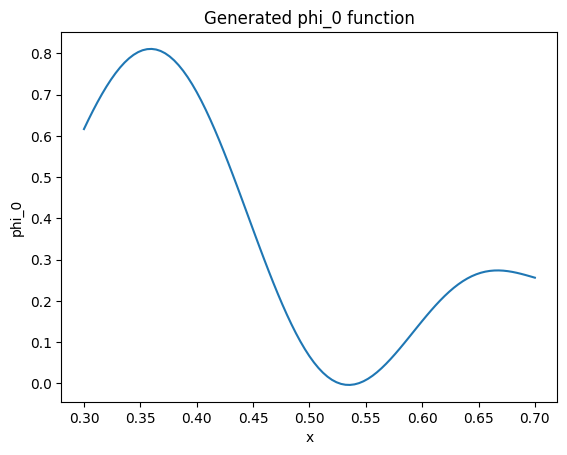

In [62]:
plt.figure()
plt.plot((x_input),tf.transpose(phi_0(x_input)))
plt.title('Generated phi_0 function')
plt.xlabel('x') #must use plt.xlable
plt.ylabel('phi_0') #must use plt.ylable

Text(0, 0.5, 'alpha')

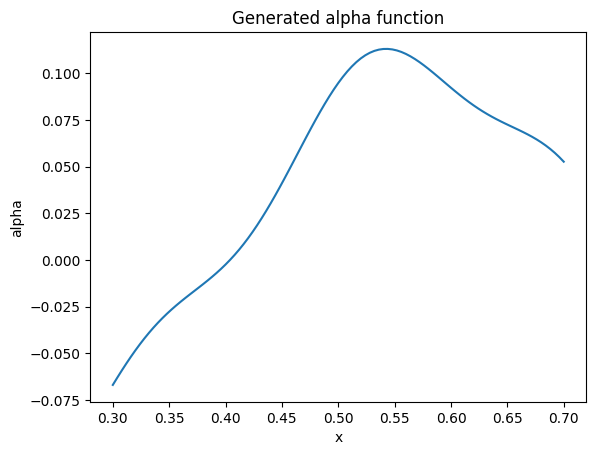

In [63]:
plt.figure()
plt.plot((x_input),tf.transpose(alph(1, x_input)))
plt.title('Generated alpha function')
plt.xlabel('x')  #must use plt.xlable
plt.ylabel('alpha') #must use plt.ylable

In [64]:
#plt.figure()
#plt.plot((x_input),tf.transpose(alpha_gauss(1, x_input)))
#plt.title('Generated alpha_gauss function')
#plt.xlabel('x')  #must use plt.xlable
#plt.ylabel('alpha_gauss') #must use plt.ylable

# creating the x_phi_1 trajectories from the generated alpha in order to get phi_1. sol_alpha.y's


Generate Phi_1 using Phi_0 function and alpha function. Here we are using solve_ivp to go forwards to time 1.
We have that $\dot{x} = \alpha(x)$, so that meanst that $\int \frac{dx}{dt} = \int \alpha(x) $ which we can estimate to:

$$x(t_{k+1}) = x(t_{k}) + h_x * \alpha(x(t_{k}))$$

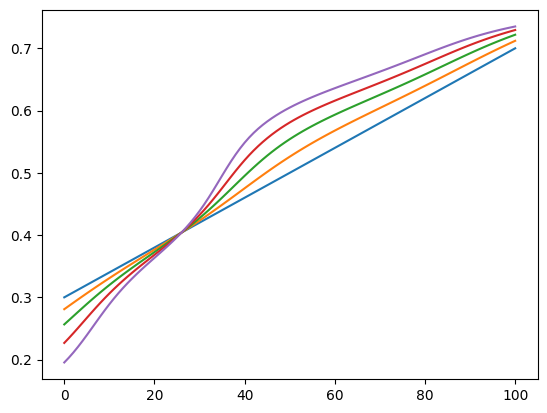

In [65]:
#sol_alpha = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)
sol_alpha = solve_ivp(alph,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)
#print(sol_test.y[:,-1])
plt.figure()
plt.plot(sol_alpha.y);

In [66]:
print(sol_alpha.y.shape)
#print(sol_test.y[:,9])
print(sol_alpha.y[:,-1].shape)
print(sol_alpha.y[0:4,:])

(101, 5)
(101,)
[[0.3        0.28095796 0.25650122 0.22676299 0.19537525]
 [0.304      0.28612067 0.26305817 0.23437128 0.20297425]
 [0.308      0.29126152 0.26965091 0.24227714 0.21122687]
 [0.312      0.29637071 0.27623883 0.2504023  0.22008677]]


In [67]:
x_phi_1 = np.reshape(sol_alpha.y[:,-1], (len(x_input), 1))
print(x_phi_1.shape)

x_phi_1 = tf.constant(x_phi_1 )
print(x_phi_1.shape)

(101, 1)
(101, 1)


In [68]:
print(x_phi_1)

tf.Tensor(
[[0.19537525]
 [0.20297425]
 [0.21122687]
 [0.22008677]
 [0.22947488]
 [0.23927643]
 [0.24934259]
 [0.25950169]
 [0.26957955]
 [0.27942246]
 [0.28891444]
 [0.29798438]
 [0.30660364]
 [0.31477791]
 [0.32253741]
 [0.32992795]
 [0.33700419]
 [0.34382507]
 [0.35045123]
 [0.35694377]
 [0.36336405]
 [0.36977409]
 [0.3762375 ]
 [0.38282048]
 [0.38959304]
 [0.39662994]
 [0.40401119]
 [0.41182138]
 [0.42014704]
 [0.42907049]
 [0.43865871]
 [0.44894575]
 [0.45990972]
 [0.47144983]
 [0.48337525]
 [0.49541916]
 [0.50728171]
 [0.51868652]
 [0.52942371]
 [0.53936367]
 [0.54844846]
 [0.55667829]
 [0.56410113]
 [0.5708009 ]
 [0.57687911]
 [0.58243521]
 [0.58755383]
 [0.59230155]
 [0.59672968]
 [0.60087902]
 [0.60478389]
 [0.60847488]
 [0.61198011]
 [0.6153256 ]
 [0.61853494]
 [0.62162899]
 [0.62462568]
 [0.62754023]
 [0.63038568]
 [0.63317342]
 [0.63591381]
 [0.63861644]
 [0.64129029]
 [0.64394376]
 [0.64658456]
 [0.6492197 ]
 [0.6518554 ]
 [0.6544971 ]
 [0.65714942]
 [0.65981622]
 [0.66250

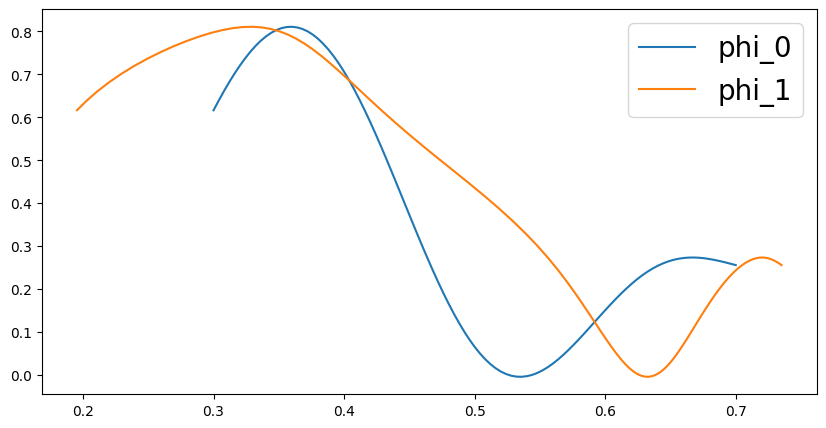

In [69]:
plt.figure(figsize=(10,5))
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(x_phi_1, np.transpose(phi_0(x_input)), label = 'phi_1') # this is phi_1. its the new x_input after
                                                                  # integration, then plot this agains
                                                                  # phi_0 true values
plt.legend(prop={'size':20});
plt.show()

# Make interplation function for phi_1

In [70]:
phi_0_fixed = phi_0(x_input)
phi_0_fixed.dtype

tf.float64

In [71]:
## tests
#ones = tf.ones((1,10), dtype = tf.float64)
#tf.matmul(x_phi_1, ones)

In [72]:
#diffOp = np.zeros((len(x_input) + 1, len(x_input)))
#diffOp[1:-1, :-1] = np.eye(len(x_input)-1) #all but the last column
#diffOp[1:-1, 1:] -= np.eye(len(x_input)-1) #all but the first column
#diffOp[0, :-1] = diffOp[1, :-1] #first row into the zeroth rom
#diffOp[-1, :] = diffOp[-2, :] # last row equals the second the last row in diffOp Added row on top and row on bot
#print(diffOp) # differnce between each x if we mulipty this operator by x
# equivalent to x[:-1] - x[1:] (what's below) where x is a column vector. It's like we
# are shifting the column up and down and subtracting

In [73]:
## create phi_1 function
# use Relu to create hat functions
# x_phi_1 as input, any x_phi _1 is zero

def phi_1(x, x_phi_1 = x_phi_1, phi_0_fixed = phi_0_fixed):
  '''
  diffOp = np.zeros((len(x_input) + 1, len(x_input)))
  diffOp[1:-1, :-1] = np.eye(len(x_input)-1) #all but the last column
  diffOp[1:-1, 1:] -= np.eye(len(x_input)-1) #all but the first column
  diffOp[0, :-1] = diffOp[1, :-1] #first row into the zeroth rom
  diffOp[-1, :] = diffOp[-2, :] # last row equals the second the last row in diffOp Added row on top and row on bot
  #print(diffOp) # differnce between each x if we mulipty this operator by x
  # equivalent to x[:-1] - x[1:] (what's below) where x is a column vector. It's like we
  # are shifting the column up and down and subtracting
  diffOp = tf.constant(diffOp, dtype = tf.float64)
  diffs = -tf.matmul(diffOp, x_phi_1)
  print(diffs.shape)
  '''
  diff_01 = np.zeros((len(x_phi_1), 1)) # is going to have two h_0s to the top
  diff_02 = np.zeros((len(x_phi_1), 1)) # is going to have h_ns to the bottom

  diff_01[1:, :] = x_phi_1[1:,:] - x_phi_1[:-1,:] #first colum of diff_01 is the differene of the shifted x_phi_1 all but the first row
  diff_01[0,0] = diff_01[1,0] # h_0, h_0, ..... h_n
  #print("diff_01")
  #print(diff_01)

  diff_02[:-1,:] = x_phi_1[1:,:] - x_phi_1[:-1,:] #:-1 is all but the last row.
  diff_02[-1, 0] = diff_02[-2, 0] # h_0, h_1,....  h_n, h_n
  #print("diff_02")
  #print(diff_02)

  diff_01 = tf.constant(diff_01, dtype = tf.float64)
  diff_02 = tf.constant(diff_02, dtype = tf.float64)

  M_diff_01 = tf.matmul(tf.ones((len(x),1),dtype=tf.float64),tf.transpose(diff_01)) #cast across columns
  M_diff_02 = tf.matmul(tf.ones((len(x),1),dtype=tf.float64),tf.transpose(diff_02)) #cast across columns
  #print("M_diff_01")
  #print(M_diff_01)
  #print("M_diff_02")
  #print(M_diff_02)
  # outproduct
  # broadcsting your x variable vector over the columns
  # then subtracting broadcasting x_phi_1 by the rows
  M = (tf.matmul(x, tf.ones((1, len(x_phi_1)), dtype = tf.float64)) - tf.matmul(tf.ones((len(x_phi_1),1), dtype = tf.float64),
                                                                               tf.transpose(x_phi_1)))
  #print("M")
  #print(M)

  hat_M = (1/M_diff_01) * tf.nn.relu(M + M_diff_01) - (1/M_diff_01 + 1/M_diff_02) * tf.nn.relu(M) + (1/M_diff_02) * tf.nn.relu(M - M_diff_02)


  #print("hat_M")
  #print(np.sum(hat_M,axis=1))
  # use

  return tf.matmul(hat_M, tf.transpose(phi_0_fixed))#h's in the picture victor drew, shoud be len(x_input) - 1 points. (distances bewteen points)


In [74]:
phi_vec = phi_1(x_input)
print(phi_vec.shape)

(101, 1)


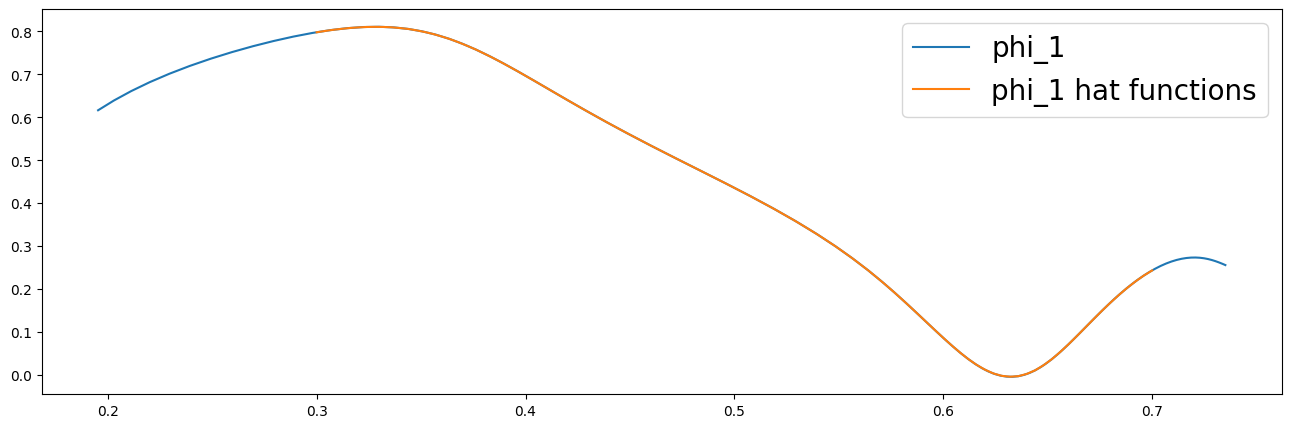

In [75]:
plt.figure(figsize=(16,5))
#plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(x_phi_1, np.transpose(phi_0(x_input)), label = 'phi_1')
plt.plot(x_input, phi_vec, label = "phi_1 hat functions")
plt.legend(prop={'size':20});
plt.show()

#Gradient descent for $\beta$.


We use this for our objective function gradient to solve for $\beta$ using gradient descent. We use $\gamma$ for our initial $\alpha$ and we make an initial guess for $\beta$.
\begin{align}
    \beta_{k+1} = \beta_k - \eta_k \nabla_{\beta} F(\gamma,\beta_k,\lambda)
\end{align}

\begin{align}
       & \nabla_{\beta} F(\gamma, \beta, \lambda) \notag \\
&= \frac{1}{n}\sum_{i=1}^n \begin{bmatrix}
    2 [\phi_1(x_i(0) + [L^*\beta]_i) - \phi_0(x_i(0))] \cdot [\phi_1'(x_i(0) + [L^*\beta]_i) ]\cdot  [L_{i1}]  \\
    2 [\phi_1(x_i(0) + [L^*\beta]_i) - \phi_0(x_i(0))] \cdot [\phi_1'(x_i(0) + [L^*\beta]_i) ]\cdot  [L_{i2}]  \\
        \vdots \\
    2 [\phi_1(x_i(0) + [L^*\beta]_i) - \phi_0(x_i(0))] \cdot [\phi_1'(x_i(0) + [L^*\beta]_i) ]\cdot  [L_{in}]
    \end{bmatrix} + 2\lambda L^*\beta
    \end{align}
Here we have that $x_i(0) \in \mathbb{R}$ where $i \in \lbrace 0, 1, \cdots (n-1)\rbrace$, $[L^*\beta]_i \in \mathbb{R}$, $L^* \in \mathbb{R}^{n\times n}$, $\beta \in \mathbb{R}^{n}$.

Our first
$$x_i(0) + [L^*\beta]_i = x_i(1) ≈ x_i(0) + \int \gamma(t) dt$$

We estimated $x_i(1)$ by using an ODE solver. We used the ODE solver to get the intermediate $x_i(t)$ for $t = 0,1,....,p-1 $. So we computed $L^*$.

## Initialize $\beta$

In [76]:
# Generate random numbers from a standard normal distribution
tf.random.set_seed(5);
Beta_ini = tf.random.normal(shape=(len(x_input), 1), mean=0.0, stddev=1.0, dtype = tf.float64)

#print("Beta_ini")
#print(Beta_ini.shape)

# make Beta_ini as close to zero as possible

#Beta_ini = tf.zeros(shape = (len(x_input),1), dtype = tf.float64)

print("Beta_ini")
print(Beta_ini.shape)

Beta_ini
(101, 1)


# Objection Function for gradient descent:
Now compute everything for my objective function:
$$ J(\beta, \lambda)  = \frac{1}{n} \sum_{i=1}^n [\phi_1 \bigg( x_i(0) + [L^*\beta]_i \bigg) - \phi_0(x_i(0))]^2 + \lambda \beta^T L^* \beta$$

In [77]:
#lam = 1e-5 # will need to tune this
phi_0_fixed = phi_0(x_input)
print(phi_0_fixed.shape)

(1, 101)


In [78]:
len(x_input)
print(Beta_ini.shape)
print(x_input.shape)
print(phi_1(x_input).shape)

(101, 1)
(101, 1)
(101, 1)


In [79]:
def objective(Lstar, BETA, lam, phi_0_fixed = phi_0_fixed, x_input = x_input):
  # L^* beta, this is a vector in R^n
  # make Lstar into a tf.constant
  #Lstar = tf.constant(Lstar)
  #Beta_ini = tf.constant(Beta_ini)
  L_beta = tf.matmul(Lstar, BETA)
  #print(f"Shape of L_beta: {L_beta.shape} should be a column vector")

  # phi_1 with this x_input + L^* beta
  input_ini = x_input + L_beta
  #print(f"input_ini shape: {input_ini.shape} should be colum vector")
  #print(input_ini)

  # phi_1(x_i(0) + [L^*beta]_i), each i in the row vector
  # this is the interpolated phi_1 function
  phi_1_est = phi_1(input_ini)#phi_0(input_ini)
  #print(f"phi_1_est shape {phi_1_est.shape} should be column vector")
  #print(phi_1_est.shape)
  #plt.plot(phi_1_est)

  # fixed phi_0(x_input) as a vector
  ###phi_0_fixed = phi_0(x_input)
  #print(phi_0_fixed.shape)

  # take phi_1_est - phi_0_fixed then take square each component
  diff = (phi_1_est - tf.transpose(phi_0_fixed))**2
  #print(f"diff should be a column vector {diff.shape} should be a column vector")
  #print(diff.shape)

  #now sum each component, diff is a column vector
  summ_1 = tf.reduce_sum(diff, axis = 0) # i don't need axis = 0 for a column vector, but maybed later
                                          # for multidimensional inputs
  #print(f"summ_1 should be a number {summ_1.shape}")
  #print(f"this is summ_1: {summ_1}")

  #\lambda B^T L * B
  summ_2 = lam * tf.matmul(tf.transpose(BETA), L_beta)
  #print(f"summ_2 is lam*B^T L* B shoulde be scalar: {summ_2.shape}")
  #print(f"summ_2 is lam*B^T L* B: {summ_2}")

  # objective
  Obj = ((1 / (len(x_input))) * summ_1) + summ_2
  #print(f"objective should be a number {Obj.shape}")

  return Obj

In [80]:
'''def objective(Lstar, Beta_ini, lam, phi_0_fixed = phi_0_fixed, x_input = x_input):
  # L^* beta, this is a vector in R^n
  L_beta = tf.matmul(Lstar, Beta_ini)
  #print(f"Shape of L_beta: {L_beta.shape} should be a column vector")

  # phi_1 with this x_input + L^* beta
  input_ini = x_input + L_beta
  #print(f"input_ini shape: {input_ini.shape} should be colum vector")
  #print(input_ini.shape)

  # phi_1(x_i(0) + [L^*beta]_i), each i in the row vector
  # this is the interpolated phi_1 function
  phi_1_est = phi_1(input_ini)#phi_0(input_ini)
  #print(f"phi_1_est shape {phi_1_est.shape} should be column vector")
  #print(phi_1_est.shape)

  # fixed phi_0(x_input) as a vector
  ###phi_0_fixed = phi_0(x_input)
  #print(phi_0_fixed.shape)

  # take phi_1_est - phi_0_fixed then take square each component
  diff = (phi_1_est - tf.transpose(phi_0_fixed))**2
  #print(f"diff should be a column vector {diff.shape} should be a column vector")
  #print(diff.shape)

  #now sum each component, diff is a column vector
  summ_1 = tf.reduce_sum(diff, axis = 0) # i don't need axis = 0 for a column vector, but maybed later
                                          # for multidimensional inputs
  #print(f"summ_1 should be a number {summ_1.shape}")
  #print(f"this is summ_1: {summ_1}")

  #\lambda B^T L * B
  #summ_2 = np.matmul(np.transpose(Beta_ini),np.matmul(Lstar, Beta_ini))


  #\lambda B^T L * B
  L = tf.matmul(Lstar, Beta_ini)
  summ_2 = lam * tf.matmul(tf.transpose(Beta_ini), L)
  #print(f"summ_2 is lam*B^T L* B: {summ_2.shape}")
  #print(f"this is summ_2: {summ_2}")

  # objective
  Obj = ((1 / (len(x_input))) * summ_1) + summ_2
  #print(f"objective should be a number {Obj.shape}")

  return Obj
'''

'def objective(Lstar, Beta_ini, lam, phi_0_fixed = phi_0_fixed, x_input = x_input):\n  # L^* beta, this is a vector in R^n\n  L_beta = tf.matmul(Lstar, Beta_ini)\n  #print(f"Shape of L_beta: {L_beta.shape} should be a column vector")\n\n  # phi_1 with this x_input + L^* beta\n  input_ini = x_input + L_beta\n  #print(f"input_ini shape: {input_ini.shape} should be colum vector")\n  #print(input_ini.shape)\n\n  # phi_1(x_i(0) + [L^*beta]_i), each i in the row vector\n  # this is the interpolated phi_1 function\n  phi_1_est = phi_1(input_ini)#phi_0(input_ini)\n  #print(f"phi_1_est shape {phi_1_est.shape} should be column vector")\n  #print(phi_1_est.shape)\n\n  # fixed phi_0(x_input) as a vector\n  ###phi_0_fixed = phi_0(x_input)\n  #print(phi_0_fixed.shape)\n\n  # take phi_1_est - phi_0_fixed then take square each component\n  diff = (phi_1_est - tf.transpose(phi_0_fixed))**2\n  #print(f"diff should be a column vector {diff.shape} should be a column vector")\n  #print(diff.shape)\n\n  #no

In [81]:
L_test = con(1/(num-1), sol_alpha.y, num, k9v)
print(L_test[0:4, 0:4])

After sol.y is flattented we have: (505, 1)
tf.Tensor(
[[0.90046473 0.90209546 0.90084736 0.89637464]
 [0.90209546 0.90684657 0.90881312 0.90760174]
 [0.90084736 0.90881312 0.91412215 0.9163355 ]
 [0.89637464 0.90760174 0.9163355  0.92209489]], shape=(4, 4), dtype=float64)


In [82]:
objective(L_test, Beta_ini, 1e-4)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.20777345]])>

## test b^T L b

In [83]:
bTl = tf.matmul(tf.transpose(Beta_ini), L_test)
bTlb = tf.matmul(bTl, Beta_ini)
print(bTlb)

lb = tf.matmul(L_test, Beta_ini)
bTlb_2 = tf.matmul(tf.transpose(Beta_ini), lb)
print(bTlb_2)

tf.Tensor([[26.77934825]], shape=(1, 1), dtype=float64)
tf.Tensor([[26.77934825]], shape=(1, 1), dtype=float64)


In [84]:
print(tf.is_tensor(Beta_ini))
print(tf.is_tensor(L_test))

True
True


In [85]:
bTl_np = np.matmul(np.transpose(Beta_ini), L_test)
bTlb_np = np.matmul(bTl_np, Beta_ini)
print(bTlb_np)

lb_np = tf.matmul(L_test, Beta_ini)
bTlb_2np = np.matmul(np.transpose(Beta_ini), lb_np)
print(bTlb_2np)

[[26.77934825]]
[[26.77934825]]


# Creating finite dimensional linear combo to learn $\alpha(x)$

Now to create new alpha function with this new beta. I will then need to do ODE solver.

In [86]:
print(h_x)
print(num)
print(1/num)
print(1/(num-1))
print(sol_alpha.y.shape)
print(Beta_ini.shape)

0.004
5
0.2
0.25
(101, 5)
(101, 1)


In [87]:
print(x_input.shape)
x_test = np.arange(0, 1, step =0.1)
print(x_test.shape)

(101, 1)
(10,)


In [88]:
## def Gamma(H, U, y, N): #N is num, y is sol.y, U is the open varialbe, H is h or 1/p
#print(Gamma(1/(num-1), x_test, sol.y, num)), or is h = 1/num?  why 1 / (num-1)
# because h = (b-a)/p. But p is x_0,x_1,...,x_p.  num is p + 1
# alos x_test is the input to the function, num is how many trajectoires and how many
# sumnands we have
print(Gamma(1/(num-1), x_test, sol_alpha.y, num, k9v).shape)

(10, 101)


In [89]:
np.dot(Gamma(1/(num-1), x_test, sol_alpha.y, num, k9v), Beta_ini)

array([[0.27096362],
       [1.18608234],
       [2.58497964],
       [1.37262542],
       [0.73276849],
       [2.91973193],
       [2.02211755],
       [2.48301634],
       [2.2812161 ],
       [0.71856023]])

In [90]:
print(1/(num-1))

0.25


In [91]:
def new_a(u, y, kern = k9v, num = num, h=(1/(num-1)), Beta_ini = Beta_ini):
  return np.dot(Gamma(1/(num-1), u, y, num, kern), Beta_ini)

In [92]:
new_a(x_test, sol_alpha.y)

array([[0.27096362],
       [1.18608234],
       [2.58497964],
       [1.37262542],
       [0.73276849],
       [2.91973193],
       [2.02211755],
       [2.48301634],
       [2.2812161 ],
       [0.71856023]])

In [93]:
def new_alpha(t, u, kern, y, num, beta, h = (1/(num-1))):
  return np.dot(Gamma(h, u, y, num, kern), beta)

In [94]:
first_iter = new_alpha(1, np.reshape(x_input,(len(x_input))), k9v, sol_alpha.y, num, Beta_ini)

(1, 101)


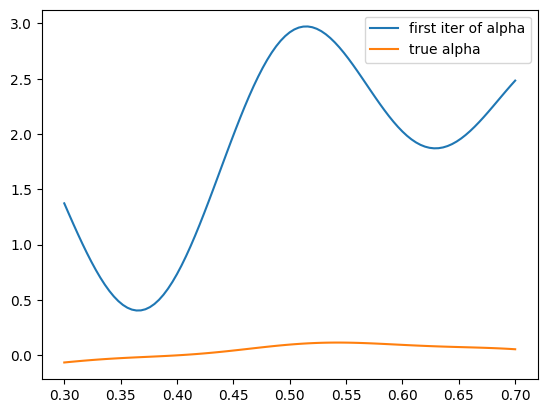

In [95]:
plt.plot(x_input, first_iter, label = 'first iter of alpha')
plt.plot(x_input, np.transpose(alph(1, x_input)), label = 'true alpha')
print(alph(1, x_input).shape)
plt.legend();

I will need to make my function with a t in it in order to use the ODE integrator

# Make ODE for $\alpha$

For the ODE solver remember that the initial condition must be (n,) shape and since my output of the new_alpha can be a vector, I must put the variable vectorized = True.

Additionally, I did a test with a function new_a_2. Here we could use alpha and put arguments in the ODE function.  

In [96]:
# projection kernel, k8v
sol_alpha_test = solve_ivp(new_alpha,[0,1],np.reshape(x_test, len(x_test)),
                           t_eval=t_list, vectorized = True,
                           args=(k8v, sol_alpha.y, num, Beta_ini))

In [97]:
sol_alpha_test.y.shape

(10, 5)

In [98]:
# new alpha using guassian kernel, k9v
#sol_alpha_test_guass = solve_ivp(new_alpha,[0,1],np.reshape(x_test, len(x_test)),
#                                t_eval=t_list, vectorized = True,
#                                args=(k9v, sol_alpha.y, num, Beta_ini))


In [99]:
#sol_alpha_test_guass.y.shape

# Make while loop.


## testing gradient descent

\begin{align}
    \beta_{k+1} = \beta_k - \eta_k \nabla_{\beta} F(\gamma,\beta_k,\lambda)
\end{align}

In [100]:
eta = 1e-1
LAM = 1e-4 #lambs[lambda_index] #1e-6
Beta = Beta_ini
#Sol.y = sol.y
LSTAR = L_test

#def objective(L_star, Beta_ini, lam, phi_0_fixed = phi_0_fixed, x_input = x_input):

for i in range(10):


  Beta = tf.Variable(Beta)
  #print(Beta)
  with tf.GradientTape() as tape:
      tape.watch(Beta)
      obj = objective(LSTAR, Beta, LAM)
  if  i % 1 == 0:
    print(i)
    print(obj)
    #print(beta_grad)
    #print(eta)
    #print(Beta)

  beta_grad = tape.gradient(obj, Beta) # this is taking the gradient

  Beta = Beta - eta * beta_grad   # gradient desecnt

0
tf.Tensor([[0.20777345]], shape=(1, 1), dtype=float64)
1
tf.Tensor([[0.20777177]], shape=(1, 1), dtype=float64)
2
tf.Tensor([[0.20777009]], shape=(1, 1), dtype=float64)
3
tf.Tensor([[0.20776842]], shape=(1, 1), dtype=float64)
4
tf.Tensor([[0.20776675]], shape=(1, 1), dtype=float64)
5
tf.Tensor([[0.20776508]], shape=(1, 1), dtype=float64)
6
tf.Tensor([[0.20776342]], shape=(1, 1), dtype=float64)
7
tf.Tensor([[0.20776176]], shape=(1, 1), dtype=float64)
8
tf.Tensor([[0.2077601]], shape=(1, 1), dtype=float64)
9
tf.Tensor([[0.20775845]], shape=(1, 1), dtype=float64)


In [101]:

# I used this to help me start my while loop
for i in range(100):


  Beta_ini = tf.Variable(Beta_ini)
  with tf.GradientTape() as tape:
      tape.watch(Beta_ini)
      obj = objective(L_test, Beta_ini, 1e-4)
  if  i % 10 == 0:
    print(i)
    print(obj)

  beta_grad = tape.gradient(obj, Beta_ini) # this is taking the gradient

  Beta_ini = Beta_ini - eta * beta_grad   # gradient desecnt


0
tf.Tensor([[0.20777345]], shape=(1, 1), dtype=float64)
10
tf.Tensor([[0.2077568]], shape=(1, 1), dtype=float64)
20
tf.Tensor([[0.20774043]], shape=(1, 1), dtype=float64)
30
tf.Tensor([[0.20772435]], shape=(1, 1), dtype=float64)
40
tf.Tensor([[0.20770855]], shape=(1, 1), dtype=float64)
50
tf.Tensor([[0.20769302]], shape=(1, 1), dtype=float64)
60
tf.Tensor([[0.21485887]], shape=(1, 1), dtype=float64)
70
tf.Tensor([[0.23100321]], shape=(1, 1), dtype=float64)
80
tf.Tensor([[0.22442941]], shape=(1, 1), dtype=float64)
90
tf.Tensor([[0.21493389]], shape=(1, 1), dtype=float64)


## While loop

At this point I have:

1.   I have x_input
2.   I have phi_0_fixed = phi_0(x_input)
3.   Gradient descent working





In [102]:
## generate a function that checks my objective function is decreasing
#1. i need to store the function outputs
#2. compare the one from the other.
#3. returen False or Ture
#4. remember to put this in to while loop after i have two things
# in the list to actually compare

def decreasing(results):
  for i in range(1, len(results)):
      if results[i] > results[i - 1]:
        return False, print(f"The obj values started Increasing at index {i}: {results[i-1]} -> {results[i]}")


  return True, print('The obj function is NOT increasing')



In [103]:
# Example usage:
my_list = [5, 4, 3, 2, 1, 1]

decreasing(my_list)
#    print("The items in the list are decreasing.")
#else:
#    print("The items in the list are not decreasing.")

The obj function is NOT increasing


(True, None)

## Find a close $\beta$:

Obtain true trajectories for true $\alpha(x)$. I did this by conducting sol_ivp for $\alpha$, then using my integral function called Gamma. Gamma outputs an $(n \times m$) matrix.  One column for each m input (each x input we provide gives a new vector).

Create $\alpha(x)$. Below is our quadrature for $\alpha$. Again $p$ is the number of intermediate trajectories we choose and $h = 1/(p-1)$.  Recall $\alpha(x) = \sum_{k=1}^n \beta_k L^*_{x_{k}}(x)$, where $L^*_{x_{k}}(x) = \int K(x, x_k(s))dt$.
\begin{align}
    &\int_0^1  K(x, x_k(s)) ds \notag \\
    &\approx \frac{h}{2} K(x, x_k(s_0)) + h  \sum_{i=1}^{p-1} K(x, x_k(s_i)) + \frac{h}{2}  K(x, x_k(s_p))
\end{align}
We use the trapezoid composite rule where $k \in \lbrace 1, \dots, n\rbrace$ and $i \in \lbrace 0,\dots, p-1 \rbrace$ for our function $\alpha$.

If dim$(x) = m$ or $(m,1)$,  $L^*_{x}(x) \in m \times n$.

I created the alpha function using the projection kernel, alpha, and I created a alpha_gauss function uisng the guassian kernel. I created vector from .1 to .9 with increments of .01. My condition number is way smaller thatn e+31, but it is still quite large. e+18.

In [104]:
# alph can be changed to alpha guassian or alpha using projection kernel
# now it is projection
#sol = solve_ivp(alph,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)


L_x = Gamma(1/(num-1), np.reshape(x_input, (len(x_input))), y = sol_alpha.y, N = num, kern = k9v)
print(sol_alpha.y.shape)
print(L_x.shape)
print(np.linalg.cond(L_x))

(101, 5)
(101, 101)
3.463505639212365e+18


Here is my true alpha vector with input of $x\_input$. This is a $(101 \times 1)$ vector. I am solving:

\begin{align*}
 \alpha(x(0)) & = L^*_x(x(0)) \beta\\
 \Rightarrow  & L^*_x(x(0))^{-1} \alpha(x(0)) = \beta
 \end{align*}

 I calculated a $beta$ by np.linalg.solve(L_x,alpha_0).

In [105]:
#alpha_0 = alpha(1, x_input) #x_input is x(0)
alpha_0 = alph(1, x_input)
#alpha_0 = alpha_0.numpy()
print(tf.transpose(alpha_0).shape)
#L_x_inv = np.linalg.inv(L_x)
#print(np.linalg.cond(L_x))
#beta_star_1 = L_x_inv @ alpha_0.T

(101, 1)


In [106]:
beta_star = tf.linalg.solve(L_x, tf.transpose(alpha_0))
print(beta_star[0:4,:])

tf.Tensor(
[[-147568.70823454]
 [ 399963.45058102]
 [-229830.3068885 ]
 [ -15283.77822569]], shape=(4, 1), dtype=float64)


In [107]:
tf.linalg.norm(L_x @ beta_star - tf.transpose(alpha_0))/np.linalg.norm(tf.transpose(alpha_0))

<tf.Tensor: shape=(), dtype=float64, numpy=7.678648798530832e-09>

In [108]:
eig_Lx, eigvec_Lx = tf.linalg.eig(L_x)


# condition number of L_x

In [109]:
print(np.linalg.cond(L_x))

3.463505639212365e+18


In [110]:
#print(eig)

In [111]:
# input beta_star into new_alpha
# k9v instead of k8v (GUASSIAN kerne using randome fourier features)
newalpha_0 = new_alpha(1, np.reshape(x_input,(len(x_input))),
                       kern = k9v,
                       y = sol_alpha.y,
                       num = num,
                       beta = beta_star)
#def new_alpha(t, u, kern, y, num, beta, h = (1/(num-1)))

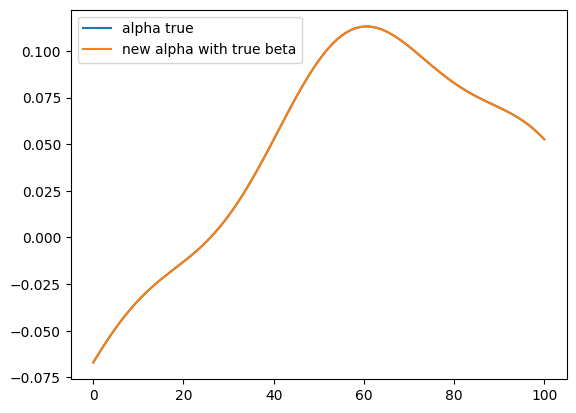

In [112]:
plt.plot(tf.transpose(alpha_0), label = 'alpha true')
plt.plot(newalpha_0, label = 'new alpha with true beta');
plt.legend();
#'''

## Testing objection function
Now, let's consider the objective function and see if $[\phi_1 \bigg( x_i(0) + [L^*\beta]_i \bigg) - \phi_0(x_i(0))]$ is close to zero.
$$ J(\beta, \lambda)  = \frac{1}{n} \sum_{i=1}^n [\phi_1 \bigg( x_i(0) + [L^*\beta]_i \bigg) - \phi_0(x_i(0))]^2 + \lambda \beta^T L^* \beta$$

In [113]:
LSTAR = con(1/(num-1), y = sol_alpha.y, num = num, kern = k9v)
print(LSTAR[4:10, 4:10])
print(np.linalg.norm(LSTAR -tf.transpose(LSTAR)))
# test bT (L b) = (bT L) b for tf for Beta_ini
print(tf.matmul(tf.transpose(Beta_ini), (tf.matmul(LSTAR, Beta_ini))))
print(tf.matmul((tf.matmul(tf.transpose(Beta_ini), LSTAR)), Beta_ini))

# test bT (L b) = (bT L) b for np for beta_star NOT
print(np.matmul(np.transpose(beta_star), (np.matmul(LSTAR, beta_star))))
print(np.matmul((np.matmul(np.transpose(beta_star), LSTAR)), beta_star))

# test bT (L b) = (bT L) b for tf for beta_star NOT
print(tf.matmul(tf.transpose(beta_star), (tf.matmul(LSTAR, beta_star))))
print(tf.matmul((tf.matmul(tf.transpose(beta_star), LSTAR)), beta_star))

After sol.y is flattented we have: (505, 1)
tf.Tensor(
[[0.93051303 0.93287136 0.93123996 0.92551547 0.91579383 0.90235771]
 [0.93287136 0.93908293 0.94131912 0.93939126 0.93331076 0.92328619]
 [0.93123996 0.94131912 0.94749259 0.94948696 0.94722622 0.94083868]
 [0.92551547 0.93939126 0.94948696 0.9554476  0.95710941 0.95451646]
 [0.91579383 0.93331076 0.94722622 0.95710941 0.96271115 0.96398987]
 [0.90235771 0.92328619 0.94083868 0.95451646 0.96398987 0.96913299]], shape=(6, 6), dtype=float64)
4.776889864539086e-15
tf.Tensor([[56.5880138]], shape=(1, 1), dtype=float64)
tf.Tensor([[56.5880138]], shape=(1, 1), dtype=float64)
[[0.06469043]]
[[0.06442284]]
tf.Tensor([[0.06414666]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.06614001]], shape=(1, 1), dtype=float64)


In [114]:
# Compute the conjugate transpose (adjoint) of the matrix
matrix_conj_transpose = tf.linalg.adjoint(LSTAR)
# Check if the matrix is equal to its conjugate transpose (Hermitian)
is_hermitian = tf.reduce_all(tf.math.equal(LSTAR, matrix_conj_transpose))

# Compute the eigenvalues of the matrix
eigenvalues= tf.linalg.eigvalsh(LSTAR)

# Check if all eigenvalues are non-negative
are_eigenvalues_non_negative = tf.reduce_all(tf.math.greater_equal(eigenvalues, 0))

# Print the results
print("Is Hermitian:", is_hermitian.numpy())
print("Are all eigenvalues non-negative:", are_eigenvalues_non_negative.numpy())

Is Hermitian: False
Are all eigenvalues non-negative: False


In [115]:
#eigenvalues

In [116]:
a = tf.constant([1, 2, 3, 4, 5, 6, 2, 1, 6], shape=[3, 3])
print(a)  # 2-D tensor

b = tf.constant([1, 2, 1], shape=[3, 1])
print(b)  # 2-D tensor

d = tf.constant([2,1,3], shape = [3,1])
print(d)

c = tf.matmul(d, tf.matmul(a, b), transpose_a = True)
print(c)  # `a` * `b`

e = tf.matmul((tf.matmul(d, a, transpose_a = True)), b)
print(e)

tf.Tensor(
[[1 2 3]
 [4 5 6]
 [2 1 6]], shape=(3, 3), dtype=int32)
tf.Tensor(
[[1]
 [2]
 [1]], shape=(3, 1), dtype=int32)
tf.Tensor(
[[2]
 [1]
 [3]], shape=(3, 1), dtype=int32)
tf.Tensor([[66]], shape=(1, 1), dtype=int32)
tf.Tensor([[66]], shape=(1, 1), dtype=int32)


In [117]:
print(tf.is_tensor(beta_star))
print(tf.is_tensor(LSTAR))

True
True


In [118]:
eig_LSTAR, vec_LSTAR = np.linalg.eig(LSTAR)
#print(eig_LSTAR)
print(np.linalg.cond(LSTAR))

8.431255001615637e+19


In [119]:
tensordot = tf.tensordot(tf.transpose(beta_star), LSTAR, axes =1 )
print(tf.tensordot(tensordot, beta_star, axes=1))
tdot = tf.tensordot(LSTAR, beta_star, axes =1)
print(tf.tensordot(tf.transpose(beta_star), tdot, axes = 1))

tf.Tensor([[0.06614001]], shape=(1, 1), dtype=float64)
tf.Tensor([[0.06414666]], shape=(1, 1), dtype=float64)


In [120]:
tf.eye(len(x_input))

<tf.Tensor: shape=(101, 101), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

In [121]:
T = tf.matmul(beta_star, tf.matmul(tf.eye(len(x_input),dtype=tf.dtypes.float64), beta_star), transpose_a = True)
print(T)
T_t = tf.matmul(tf.matmul(beta_star, tf.eye(len(x_input),dtype=tf.dtypes.float64), transpose_a = True), beta_star)
print(T_t)

tf.Tensor([[1.88647189e+13]], shape=(1, 1), dtype=float64)
tf.Tensor([[1.88647189e+13]], shape=(1, 1), dtype=float64)


In [122]:
bsTls = tf.matmul(tf.transpose(beta_star), k9v(x_input,x_input))
bsTlsb = tf.matmul(bsTls , beta_star)
print(bsTlsb)

lbs = tf.matmul(k9v(x_input,x_input), beta_star)
bsTlsbs_2 = tf.matmul(tf.transpose(beta_star), lbs)
print(bsTlsbs_2)

tf.Tensor([[1.0337033e+09]], shape=(1, 1), dtype=float64)
tf.Tensor([[1.0337033e+09]], shape=(1, 1), dtype=float64)


After sol.y is flattented we have: (505, 1)
this is from the objective function with beta_star: [[8.40001512e-06]]
tf.Tensor([[6.41466626e-06]], shape=(1, 1), dtype=float64)
(101, 1)
error norm: 0.0031112888271977042
loss function test: [[8.40001504e-06]]
loss function with beta_star_2: f[[8.40001512e-06]]


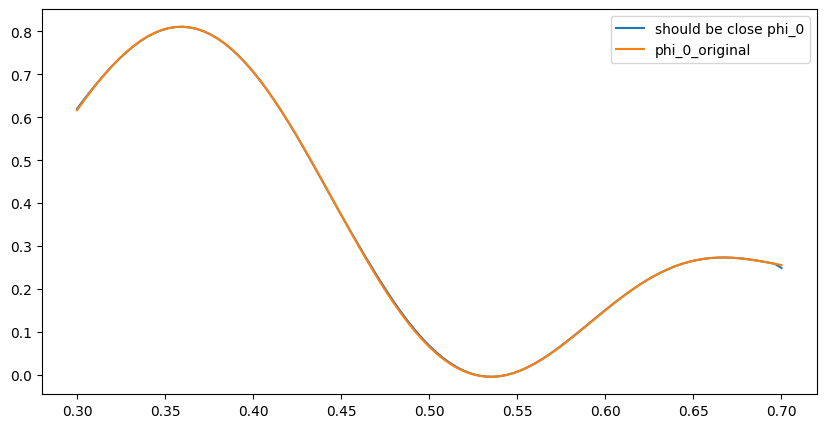

In [123]:
# let's look at objective function with TRUE trajectories:
# Our goal is to show that phi_1(x(1)) ~ phi_0(X(0)), i.e. our outputs should
# equal for phi_1 and phi_0. Using our objection function, I calculted phi_1(x(0) + LB). This
# should be very close to phi_0(X(0)).


LAM = 10**2 * 1e-6

# theta3 is used for alpha.
# solve.y uses our true x trajectoires
# this LSTAR uses true x trajectories to solve for obj function
# use k9v
LSTAR = con(1/(num-1), y = sol_alpha.y, num = num, kern = k9v)
#print(LSTAR)
print(f"this is from the objective function with beta_star: {objective(LSTAR, beta_star, LAM)}")

########
#Test out objective function
########

# I do lstar, beta then i do trapnose(beta)
#BTB = tf.matmul(tf.transpose(beta_star), LSTAR)
#BTLB = tf.matmul(BTB, beta_star)

LB = tf.matmul(LSTAR, beta_star) #Beta_ini)
#print(LB)
#print(LB.shape)
BTLB = tf.matmul(tf.transpose(beta_star), LB) #tf.matmul(tf.transpose(Beta_ini), LB)

print(LAM * BTLB)

############
input = x_input + np.matmul(LSTAR, beta_star)
print(input.shape)
phi_1_est = phi_1(input)
error = (phi_1_est - tf.transpose(phi_0_fixed))**2
print(f'error norm: {np.linalg.norm(phi_1_est - tf.transpose(phi_0_fixed))/np.linalg.norm(tf.transpose(phi_0_fixed))}')
summ_1 = tf.reduce_sum(error, axis = 0)
loss_test = ((1 / (len(x_input)) ) * summ_1) + LAM * BTLB
print(f'loss function test: {loss_test}')
print(f'loss function with beta_star_2: f{objective(LSTAR, beta_star, LAM)}')

plt.figure(figsize=(10,5))
#plt.plot(solve.y[:,-1], np.transpose(phi_0(x_input)), label = 'phi_1_original')

# these values should be close, regardless of what they are being plotted against.
plt.plot(x_input, phi_1_est, label = 'should be close phi_0');
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0_original')


plt.legend();

In [124]:
print(LSTAR[0:4, 0:4])

tf.Tensor(
[[0.90046473 0.90209546 0.90084736 0.89637464]
 [0.90209546 0.90684657 0.90881312 0.90760174]
 [0.90084736 0.90881312 0.91412215 0.9163355 ]
 [0.89637464 0.90760174 0.9163355  0.92209489]], shape=(4, 4), dtype=float64)


In [125]:
objective(LSTAR, beta_star, LAM)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[8.40001512e-06]])>

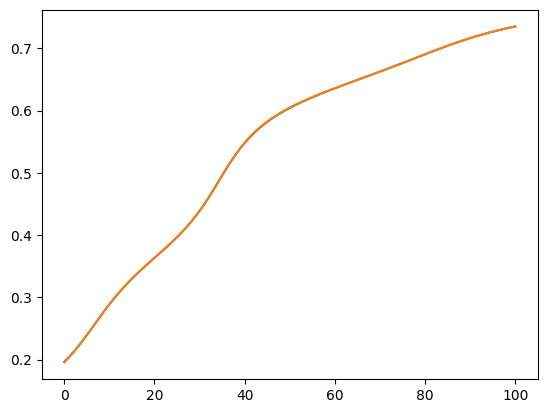

In [126]:
plt.plot(input) #input = x(0) + LB_i
plt.plot(sol_alpha.y[:,-1]);

## While loop testing => use this for close $\beta$

After sol.y is flattented we have: (505, 1)
1
obj_old with Beta: [[2.04949552e-06]]
2
obj_old with Beta: [[2.04949552e-06]]
2
Here is the objective function results at 2 iterations: [[2.04949552e-06]]
the value of eta: 7.888609052210118e-31
tf.Tensor([[2.04949552e-06]], shape=(1, 1), dtype=float64)
1.6840193271636963


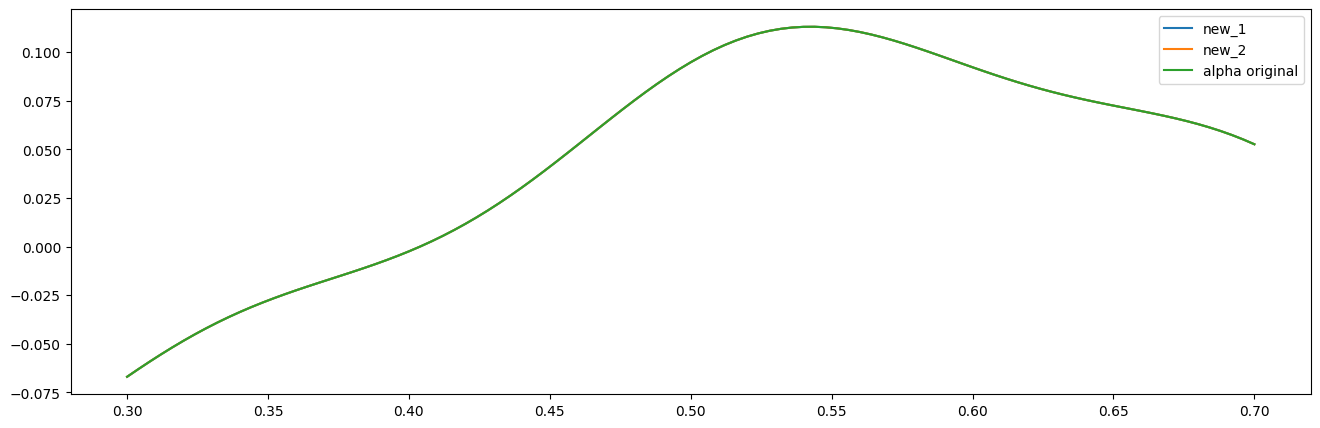

In [127]:
#TEST
#get start time
#eta = ((2**5)/(2**1)) * 1e-3 #(2**5) * 1e-3
#print(f"This is the first eta: {eta}")
st = time.time()
mm = 0 # not zero since beta_ini is zero vector at virst
        # we can't divide by zero
var = 0
var_2 = 0
LAM = (10**0) * 1e-6 #lambs[lambda_index] #1e-6
Beta = beta_star #Beta_ini
gradient_step = 2
#sol = sol_1.y
#LSTAR = Lsk_alpha #Lsk_alpha# Lsk_alpha is with true trajectories, Lsk_0
OBJ = [] #put the results in this list to compare the elements for GD
OBJ_2 = [] #lstar obj restulst

#initialize the firts sol.y
#sol = solve_ivp(f,[0,1],np.reshape(x_input,len(x_input)),t_eval=t_list)
##initial the first sol_alpha.y's with true trajecotires.
# sol = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)
sol = solve_ivp(alph,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)
# k9v
#L_x = Gamma(1/(num-1), np.reshape(x_input, (len(x_input))), y = sol.y, N = num, kern = k9v)
LSTAR = con(1/(num-1), y = sol.y, num = num, kern = k9v)


# measuring error
beta_vector = np.zeros((len(x_input),600))
beta_vector[:,0:1] = Beta  #put beta in first column
diff_beta = np.zeros(100)
diff = np.zeros(600)
plt.figure(figsize=(16,5))

cond = True
cond_2 = True

while(cond):


    mm += 1
    print(mm)

    # Gradient Desecent
    for i in range(1):
    #while(cond_2):
      eta = 1 / (2**100)#2.5 * (1e-4)#3**1 * 1e-2 #.01
      #sol_alpha = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)
      #Lsk_alpha = con(h_x, sol_alpha.y, num, k8v) #Lsk_alpha is with true trajectories,
      ##print(f"eta initialized {eta}")

      Beta = tf.Variable(Beta)
      with tf.GradientTape() as tape:
          tape.watch(Beta)
          #print(Beta)


      # Check the modulo condition
      #var += 1
      #if var % 10 == 0:
          #print(var)
          #print(f"Here is the obj value for GD: {obj}")
      #print("Is GD obj decrease?")
      #print(decreasing(OBJ))
          obj = objective(LSTAR, Beta, LAM)
          print(f"obj_old with Beta: {obj}")
          #print(f"This is gradient {i}th iteration obj_old: {obj}")


      beta_grad = tape.gradient(obj, Beta) # this is taking the gradient
      #print(np.linalg.norm(beta_grad))
      #print(beta_grad)
      #print(np.sum(beta_grad**2))

      #Beta = Beta - eta * (beta_grad / np.linalg.norm(beta_grad)) # gradient desecn
      Beta = Beta - eta * beta_grad

      #obj_1 = obj.numpy()  #make obj into a numpy
      #obj_old = np.copy(obj_1) #-1
      #make new obj
      #obj_new = objective(LSTAR, Beta, LAM)
      #print(f"obj_new with Beta after GD: {obj_new}")

      '''
      #kamel's test
      obj_1 = obj.numpy()  #make obj into a numpy
      obj_old = np.copy(obj_1) - 1
      #OBJ.append(float(obj_1)) #make numpy into a float
      '''
      '''
      #if decreasing(OBJ)[0] == False:
      while obj_new > obj_old: #obj_1 > obj_old:
        print("obj is increasing")
        #obj_old = np.copy(obj_1)

        print(f"GD: This is the iteration where it increased: {mm}, {obj_new} > {obj_old}")
        #print(f"GD: print the var variable {var}")
        #cond = False #stop algorithm
        eta = eta / 2
        print(f"Eta changed: {eta}")
        Beta = Beta - eta *  (beta_grad / np.linalg.norm(beta_grad))
        #Beta = Beta - eta * beta_grad
        obj_new = objective(LSTAR, Beta, LAM)
        #obj_1 = obj.numpy() #make obj into a numpy
        #obj_old = np.copy(obj_1)
        # do GD
      '''
        #then recheck that decreasing(OBJ)[0] == True
            #print(f"objection funcion is increasing, change eta to: {eta}")
        #print("This is the value I'm looking for:" , {diff[mm]})

      # Increment the value
      #var += 1

      '''
      if  i % 50 == 0:
        print(i)
        print(obj)
      '''







      #print(f"GD Obj values: {OBJ}")
      #print(f"GD obj: {float(obj_1)}")
      # error
      beta_vector[:,mm:mm+1] = Beta

      if mm >= 2: # after 2 since beta = 0 at the first iteration, we need the second and third composnents.
      # check for convergence, using relative error
      #diff_beta[mm] = np.linalg.norm(beta_vector[:,mm-1:mm] - beta_vector[:,mm:mm+1]) / np.linalg.norm(beta_vector[:,mm-1:mm])
      #print(diff_beta[mm])
      #if diff_beta[mm] < 1e-2:
      #  print(diff_beta[mm])
      #  cond_2 = False
      #  break

        diff[mm] = np.sqrt( ((beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm]).T @ LSTAR @
                                                    (beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm])
                                                    ) / (beta_vector[:,mm-1:mm].T @ LSTAR
                                                         @ beta_vector[:,mm-1:mm] )
                                                      )
      #print("This should be the same: ", {diff[mm]})


    #if mm % 4 == 0:  #if m modulo constant occurs, print m
    #    rem = mm
    #    print('Iteration count: ' +str(rem))
    #    print('Convergence using norm of RKHS at '+str(rem) +'iterations: ' +str(diff[mm]))
    #    print('Beta norm error: '+str(diff[mm]))
    '''  if diff[mm] < 0.01:
        print('This is the norm difference of the RKHS norm: ', {diff[mm]})
          #print('Iteration count: ' +str(mm))
          #print('Convergence using norm of RKHS at '+str(mm) +'iterations: ' +str(diff[mm]))
          #print('Beta norm error: '+str(diff[mm]))
        cond_2 = False
    '''

  # ODEvsolver. Put arguments for sol.y and num in here
  #'''
    #if mm % 15 == 0:
    #  print('Here is were we change the eta, i think we need an epoch loop')
    #  print(mm)

    #sol = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
    #              t_eval=t_list,
    #              vectorized = True,
    #              args=(k8v, sol.y, num, Beta))

  #'''

  # test out original alpha
    #sol = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)

    #plt.plot(x_input, np.transpose(alpha(1, x_input)), label = f"new_{mm}")
    #k9v


    plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k9v,
                            y = sol.y, #keep true traj
                            num = num,
                            beta= Beta), label = f'new_{mm}')


  #Make new L_star with ODE solver data
    # removed so we can use original Lsk_alpha which is the same thing if we use
    # sol_ivp for true alpha
    #LSTAR = con(h_x, sol.y, num, k8v)


    #if mm % 50 == 0:
    #obj_2 = objective(LSTAR, Beta, LAM)
    #obj_2 = obj_2.numpy() #make obj into a numpy
    #OBJ_2.append(float(obj_2)) #make numpy into a float

    #var_2 += 1
    #if var_2 % 10 == 0:
    #print(f"Here is the obj value for LSTAR: {obj_2}")
    #print("Is LSTAR obj decrease?")
    #print(decreasing(OBJ_2))
    #if decreasing(OBJ_2)[0] == False:
    #  print(f"LSTAR: This is the iteration where we stopped: {mm}")
    #  cond = False

        #eta = eta / 2
        #print(f"objection funcion is increasing, change eta to: {eta}")

  #print(f"LSTAR change objective: {OBJ_2}")
  #print(f"LSTAR obj: {float(obj_2)}")
  # after gradient descent we should still decrease objective
  # compare to the last gradeint desecent objective print
  # compare the LSTAR
  # plot this
  #print(obj)

    if mm % gradient_step == 0:
      print(mm)
      print(f"Here is the objective function results at {mm} iterations: {objective(LSTAR, Beta, LAM)}")
      print(f"the value of eta: {eta}")
      cond = False # stop algorithm
      #if decreasing(OBJ)[0] and decreasing(OBJ_2)[0] == True:
      #  eta = eta / 2
#        print(f"this is the same eta: {eta}")
#      else:
#        eta = eta / 2
#        print(f"objection funcion is increasing, change eta to: {eta}")

plt.plot(x_input, np.transpose(alph(1, x_input)), label = 'alpha original')
plt.legend()
print(obj)
et = time.time()
total_time = et - st
print(total_time)
#print("GD obj list: ")
#print(decreasing(OBJ))
#print("LSTAR obj list:")
#print(decreasing(OBJ_2))


In [128]:
print(np.linalg.norm(beta_star - Beta) / np.linalg.norm(beta_star))
#plt.plot(x_input, beta_star_2, label = 'Beta using original alpha and L_x pseduo invers')
#plt.plot(x_input, Beta, label = 'GD Beta')
#plt.legend();

0.0


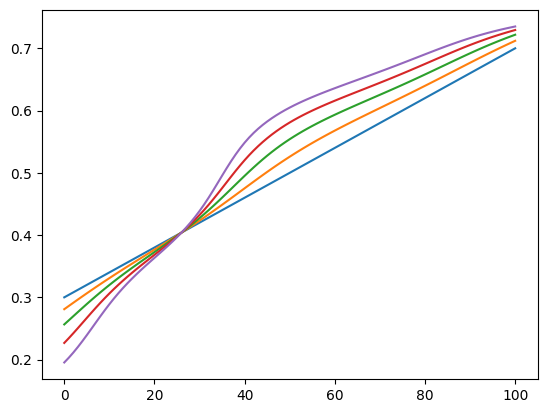

In [129]:
# sol - true trajectoires, how x changes based on integrating with alpha
# k9v
solve_Beta = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
                  t_eval=t_list,
                  vectorized = True,
                  args=(k9v, sol.y, num, Beta))

plt.plot(solve_Beta.y);

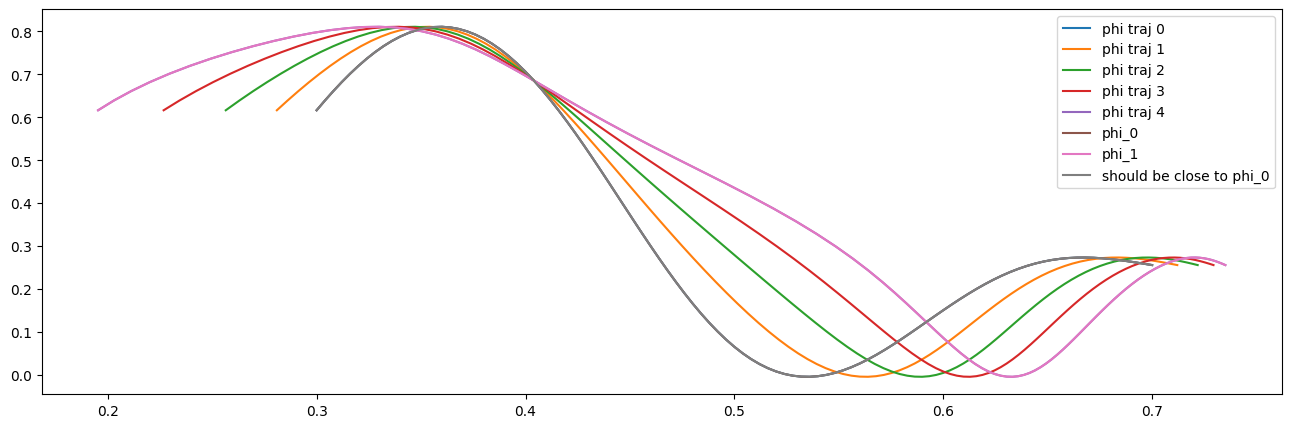

In [130]:
plt.figure(figsize=(16,5))
for i in range(len(solve_Beta.y[0])):
  plt.plot(solve_Beta.y[:,i], np.transpose(phi_0(x_input)), label = f'phi traj {i}')

plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(x_phi_1, np.transpose(phi_0(x_input)), label = 'phi_1')
plt.plot(x_input, phi_1(np.reshape(solve_Beta.y[:,-1], (len(x_input),1))), label = 'should be close to phi_0')
plt.legend();

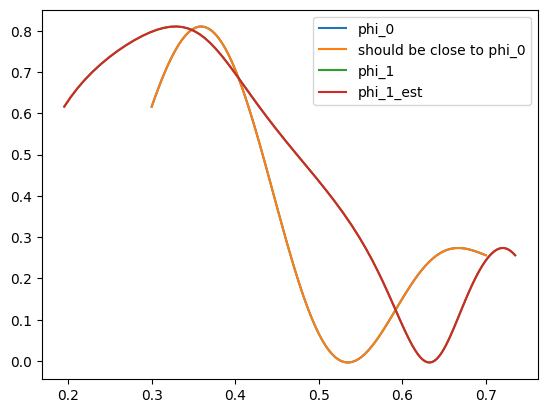

In [131]:
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(x_input, phi_1(np.reshape(solve_Beta.y[:,-1], (len(x_input),1))), label = 'should be close to phi_0');
plt.plot(x_phi_1, np.transpose(phi_0(x_input)), label = 'phi_1')
plt.plot(np.reshape(solve_Beta.y[:,-1], (len(x_input),1)), np.transpose(phi_0(x_input)), label = 'phi_1_est')

plt.legend();

## Infor on phi_0 and phi_ 1like DTW

In [132]:
print(new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k9v,
                            y = sol.y, #keep true traj
                            num = num,
                            beta= Beta).shape)

(101, 1)


In [133]:
'''plt.figure(figsize=(10,5))
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
offset = 2

plt.plot(x_phi_1, np.transpose(phi_0(x_input)) + offset, label = 'phi_1') # this is phi_1. its the new x_input after
                                                                  # forward euler, then plot this agains

for i in range(1, len(alpha_0.T)):
  pt = (x_input.numpy()[i], np.transpose(phi_0(x_input))[i])
  slope = alpha_0.T[i]
  b = pt[1] - slope * pt[0]
  pt1 = (x_phi_1[i], slope * (np.transpose(phi_0(x_input))[i]) + b + offset)
  plt.plot((pt1[0], pt[0]), (pt1[1], pt[1]),linestyle='--')

plt.plot()
plt.legend(prop={'size':20});
plt.show();
'''
'''
#import matplotlib.pyplot as plt
pt = (0.01,-0.38773961)
slope = -5.43027049e-03
pt_1 = (0.02,-0.44777292)
slope_1 = -1.08374759e-02
#pt = (3, 4)
#slope = -2
# Given the above, calculate y intercept "b" in y=mx+b
b_1 = pt[1] - slope * pt[0]
b_2 = pt_1[1] - slope * pt_1[0]

# Now draw two points around the input point
pt1 = (pt[0] - (5.81163294e-03), slope * (pt[0] - (-0.4930057  )) + b_1 + offset)
pt2 = (pt_1[0]- (1.16230087e-02), slope * (pt_1[0] - (-0.59172036)) + b_2 + offset)

# Draw two line segments around the input point
plt.plot((pt1[0], pt[0]), (pt1[1], pt[1]),linestyle='--')
plt.plot((pt_1[0], pt2[0]), (pt_1[1], pt2[1]),  linestyle='dashed')


plt.plot()
plt.legend(prop={'size':20});
plt.show()
'''

'\n#import matplotlib.pyplot as plt\npt = (0.01,-0.38773961)\nslope = -5.43027049e-03\npt_1 = (0.02,-0.44777292)\nslope_1 = -1.08374759e-02\n#pt = (3, 4)\n#slope = -2\n# Given the above, calculate y intercept "b" in y=mx+b\nb_1 = pt[1] - slope * pt[0]\nb_2 = pt_1[1] - slope * pt_1[0]\n\n# Now draw two points around the input point\npt1 = (pt[0] - (5.81163294e-03), slope * (pt[0] - (-0.4930057  )) + b_1 + offset)\npt2 = (pt_1[0]- (1.16230087e-02), slope * (pt_1[0] - (-0.59172036)) + b_2 + offset)\n\n# Draw two line segments around the input point\nplt.plot((pt1[0], pt[0]), (pt1[1], pt[1]),linestyle=\'--\')\nplt.plot((pt_1[0], pt2[0]), (pt_1[1], pt2[1]),  linestyle=\'dashed\')\n\n\nplt.plot()\nplt.legend(prop={\'size\':20});\nplt.show()\n'

In [134]:
'''
plt.figure(figsize=(16,5))
print(solve_Beta.y[0,0])
print(np.transpose(phi_0(x_input))[0,0])
point1 = (solve_Beta.y[0,0], np.transpose(phi_0(x_input))[0,:])
print(point1)
point2 = (solve_Beta.y[0,1], np.transpose(phi_0(x_input))[0,:])
print(point2)
point3 = (solve_Beta.y[0,2], np.transpose(phi_0(x_input))[0,:])
print(point3)
point4 = (solve_Beta.y[0,3], np.transpose(phi_0(x_input))[0,:])
print(point4)
point5 = (solve_Beta.y[0,4], np.transpose(phi_0(x_input))[0,:])


# Unpack the coordinates
x1, y1 = point1
x2, y2 = point2
x3, y3 = point3
x4, y4 = point4
x5, y5 = point5

# Plot the points
plt.plot([x1, x2], [y1, y2], marker='o', linestyle='-')
plt.plot([x2, x3], [y2, y3], marker='o', linestyle='-')
plt.plot([x3, x4], [y3, y4], marker='o', linestyle='-')
plt.plot([x4, x5], [y4, y5], marker='o', linestyle='-')
'''

"\nplt.figure(figsize=(16,5))\nprint(solve_Beta.y[0,0])\nprint(np.transpose(phi_0(x_input))[0,0])\npoint1 = (solve_Beta.y[0,0], np.transpose(phi_0(x_input))[0,:])\nprint(point1)\npoint2 = (solve_Beta.y[0,1], np.transpose(phi_0(x_input))[0,:])\nprint(point2)\npoint3 = (solve_Beta.y[0,2], np.transpose(phi_0(x_input))[0,:])\nprint(point3)\npoint4 = (solve_Beta.y[0,3], np.transpose(phi_0(x_input))[0,:])\nprint(point4)\npoint5 = (solve_Beta.y[0,4], np.transpose(phi_0(x_input))[0,:])\n\n\n# Unpack the coordinates\nx1, y1 = point1\nx2, y2 = point2\nx3, y3 = point3\nx4, y4 = point4\nx5, y5 = point5\n\n# Plot the points\nplt.plot([x1, x2], [y1, y2], marker='o', linestyle='-')\nplt.plot([x2, x3], [y2, y3], marker='o', linestyle='-')\nplt.plot([x3, x4], [y3, y4], marker='o', linestyle='-')\nplt.plot([x4, x5], [y4, y5], marker='o', linestyle='-')\n"

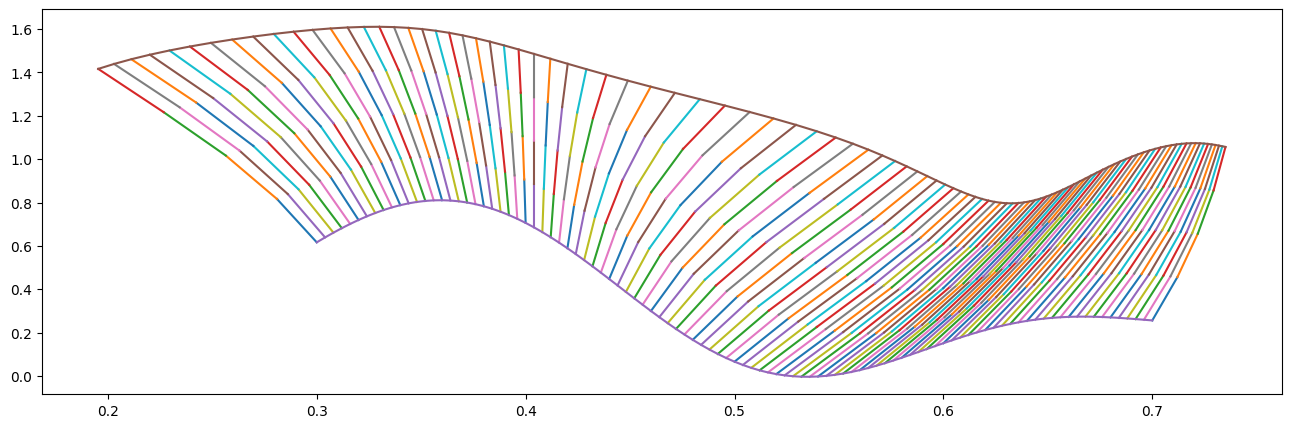

In [135]:
plt.figure(figsize=(16,5))
offset_multiplier = 0.2
for j in range(len(solve_Beta.y)):
  for i in range(0,(num-1)):
    point1 = (solve_Beta.y[j,i], np.transpose(phi_0(x_input))[j,:])
    point2 = (solve_Beta.y[j,i+1], np.transpose(phi_0(x_input))[j,:])


    # Calculate Y offset for each line segment
    y_offset1 = i * offset_multiplier
    y_offset2 = (i + 1) * offset_multiplier
    #print(y_offset2)

    x1, y1 = point1
    x2, y2 = point2
    plt.plot([x1, x2], [y1+y_offset1, y2+y_offset2], linestyle='-')


plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0');
plt.plot(x_phi_1, np.transpose(phi_0(x_input))+((offset_multiplier * (num-1))), label = 'phi_1');

## Add noise to Beta_Star

In [136]:
percent_error = 1*np.exp(-20)
print(percent_error)
n_3 = np.linalg.norm(beta_star)

2.061153622438558e-09


0.008952318619295439
[[ 1.32819220e-03]
 [ 6.77957898e-05]
 [ 1.48951487e-04]
 [-6.19315676e-05]
 [-1.71602370e-03]
 [ 1.23867143e-04]
 [-1.28523831e-03]
 [ 1.80743156e-04]
 [-4.77912015e-04]
 [ 9.28528801e-04]]
                  0
count  1.010000e+02
mean  -6.389934e-04
std    4.343353e+05
min   -1.059519e+06
25%   -2.717887e+05
50%   -2.925631e+04
75%    2.682446e+05
max    1.641191e+06
                  0
count  1.010000e+02
mean  -7.874586e-04
std    4.343353e+05
min   -1.059519e+06
25%   -2.717887e+05
50%   -2.925631e+04
75%    2.682446e+05
max    1.641191e+06


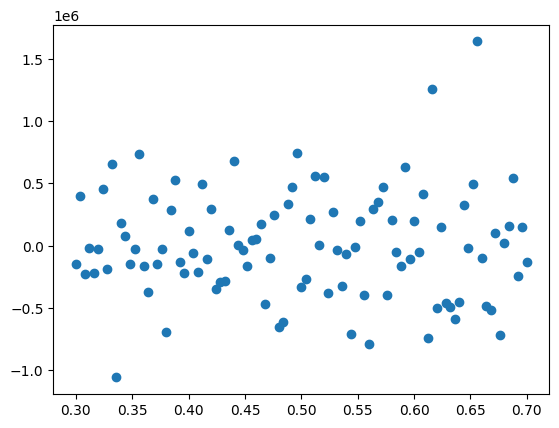

In [137]:
np.random.seed(14)
mu, sigma = 0, .03 # mean and standard deviation
s = np.random.normal(mu, sigma, size=(len(x_input),1))
s = s * (n_3 / np.linalg.norm(s)) * percent_error
print(np.linalg.norm(s))
print(s[0:10,:])
beta_noise = s + beta_star
#plt.plot(beta_star_3);
plt.scatter(x_input, beta_star);
df_describe = pd.DataFrame(beta_star)
print(df_describe.describe())
df_describe_noise = pd.DataFrame(beta_noise)
print(df_describe_noise.describe())

In [138]:
#beta_star_elimnate= beta_star_3[1:-1]
#df_describe_eli = pd.DataFrame(beta_star_elimnate)
#x_eli = x_input[1:-1]
#print(df_describe_eli.describe())
#plt.scatter(x_eli, beta_star_elimnate)

In [ ]:
#TEST
#get start time
#eta = ((2**5)/(2**1)) * 1e-3 #(2**5) * 1e-3
#print(f"This is the first eta: {eta}")
st = time.time()
mm = 0 # not zero since beta_ini is zero vector at virst
        # we can't divide by zero
var = 0
var_2 = 0
LAM = (10**0) * 1e-3 #lambs[lambda_index] #1e-6
Beta = beta_noise#beta_star_3 #Beta_ini
gradient_step = 100
#sol = sol_1.y
#LSTAR = Lsk_alpha #Lsk_alpha# Lsk_alpha is with true trajectories, Lsk_0
OBJ = [] #put the results in this list to compare the elements for GD
OBJ_2 = [] #lstar obj restulst

#initialize the firts sol.y
#sol = solve_ivp(f,[0,1],np.reshape(x_input,len(x_input)),t_eval=t_list)
##initial the first sol_alpha.y's with true trajecotires.
sol = solve_ivp(alph,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)

newalpha_0 = new_alpha(1, np.reshape(x_input,(len(x_input))), kern = k9v, y = sol.y, num = num, beta = beta_star)

#sol_noise = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
#                t_eval=t_list,
#                vectorized = True,
#                args=(k9v, sol.y, num, beta_noise))

#def new_alpha(t, u, kern, y, num, beta, h = (1/(num-1)))
LSTAR = con(1/(num-1), y = sol.y, num = num, kern = k9v)

# measuring error
beta_vector = np.zeros((len(x_input),600))
beta_vector[:,0:1] = Beta  #put beta in first column
diff_beta = np.zeros(100)
diff = np.zeros(600)
plt.figure(figsize=(16,5))

cond = True
cond_2 = True

while(cond):


    mm += 1
    print(mm)

    # Gradient Desecent
    for i in range(1):
    #while(cond_2):
      eta = 1 / (2**10)#2.5 * (1e-4)#3**1 * 1e-2 #.01
      #sol_alpha = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)
      #Lsk_alpha = con(h_x, sol_alpha.y, num, k8v) #Lsk_alpha is with true trajectories,
      ##print(f"eta initialized {eta}")

      Beta = tf.Variable(Beta)
      with tf.GradientTape() as tape:
          tape.watch(Beta)
          obj = objective(LSTAR, Beta, LAM)
          print(f"obj_old with Beta: {obj}")
          #print(f"This is gradient {i}th iteration obj_old: {obj}")


      beta_grad = tape.gradient(obj, Beta) # this is taking the gradient
      #print(np.linalg.norm(beta_grad))
      #print(beta_grad)
      #print(np.sum(beta_grad**2))

      Beta = Beta - eta * (beta_grad / np.linalg.norm(beta_grad)) # gradient desecn
      #Beta = Beta - eta * beta_grad

      obj_1 = obj.numpy()  #make obj into a numpy
      obj_old = np.copy(obj_1) #-1
      #make new obj
      obj_new = objective(LSTAR, Beta, LAM)
      #print(f"obj_new with Beta after GD: {obj_new}")

      '''
      #kamel's test
      obj_1 = obj.numpy()  #make obj into a numpy
      obj_old = np.copy(obj_1) - 1
      #OBJ.append(float(obj_1)) #make numpy into a float
      '''
      '''
      #if decreasing(OBJ)[0] == False:
      while obj_new > obj_old: #obj_1 > obj_old:
        print("obj is increasing")
        #obj_old = np.copy(obj_1)

        print(f"GD: This is the iteration where it increased: {mm}, {obj_new} > {obj_old}")
        #print(f"GD: print the var variable {var}")
        #cond = False #stop algorithm
        eta = eta / 2
        print(f"Eta changed: {eta}")
        Beta = Beta - eta *  (beta_grad / np.linalg.norm(beta_grad))
        #Beta = Beta - eta * beta_grad
        obj_new = objective(LSTAR, Beta, LAM)
        #obj_1 = obj.numpy() #make obj into a numpy
        #obj_old = np.copy(obj_1)
        # do GD
      '''
        #then recheck that decreasing(OBJ)[0] == True
            #print(f"objection funcion is increasing, change eta to: {eta}")
        #print("This is the value I'm looking for:" , {diff[mm]})

      # Increment the value
      #var += 1

      '''
      if  i % 50 == 0:
        print(i)
        print(obj)
      '''







      #print(f"GD Obj values: {OBJ}")
      #print(f"GD obj: {float(obj_1)}")
      # error
      beta_vector[:,mm:mm+1] = Beta

      if mm >= 2: # after 2 since beta = 0 at the first iteration, we need the second and third composnents.
      # check for convergence, using relative error
      #diff_beta[mm] = np.linalg.norm(beta_vector[:,mm-1:mm] - beta_vector[:,mm:mm+1]) / np.linalg.norm(beta_vector[:,mm-1:mm])
      #print(diff_beta[mm])
      #if diff_beta[mm] < 1e-2:
      #  print(diff_beta[mm])
      #  cond_2 = False
      #  break

        diff[mm] = np.sqrt( ((beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm]).T @ LSTAR @
                                                    (beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm])
                                                    ) / (beta_vector[:,mm-1:mm].T @ LSTAR
                                                         @ beta_vector[:,mm-1:mm] )
                                                      )
      #print("This should be the same: ", {diff[mm]})


    #if mm % 4 == 0:  #if m modulo constant occurs, print m
    #    rem = mm
    #    print('Iteration count: ' +str(rem))
    #    print('Convergence using norm of RKHS at '+str(rem) +'iterations: ' +str(diff[mm]))
    #    print('Beta norm error: '+str(diff[mm]))
    '''  if diff[mm] < 0.01:
        print('This is the norm difference of the RKHS norm: ', {diff[mm]})
          #print('Iteration count: ' +str(mm))
          #print('Convergence using norm of RKHS at '+str(mm) +'iterations: ' +str(diff[mm]))
          #print('Beta norm error: '+str(diff[mm]))
        cond_2 = False
    '''

  # ODEvsolver. Put arguments for sol.y and num in here
  #'''
    #if mm % 15 == 0:
    #  print('Here is were we change the eta, i think we need an epoch loop')
    #  print(mm)

    #sol = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
    #              t_eval=t_list,
    #              vectorized = True,
    #              args=(k8v, sol.y, num, Beta))

  #'''

  # test out original alpha
    #sol = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)

    #plt.plot(x_input, np.transpose(alpha(1, x_input)), label = f"new_{mm}")

    plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k9v,
                            y = sol.y, #keep true traj
                            num = num,
                            beta= Beta), label = f'new_{mm}')


  #Make new L_star with ODE solver data
    # removed so we can use original Lsk_alpha which is the same thing if we use
    # sol_ivp for true alpha
    #LSTAR = con(h_x, sol.y, num, k8v)


    #if mm % 50 == 0:
    #obj_2 = objective(LSTAR, Beta, LAM)
    #obj_2 = obj_2.numpy() #make obj into a numpy
    #OBJ_2.append(float(obj_2)) #make numpy into a float

    #var_2 += 1
    #if var_2 % 10 == 0:
    #print(f"Here is the obj value for LSTAR: {obj_2}")
    #print("Is LSTAR obj decrease?")
    #print(decreasing(OBJ_2))
    #if decreasing(OBJ_2)[0] == False:
    #  print(f"LSTAR: This is the iteration where we stopped: {mm}")
    #  cond = False

        #eta = eta / 2
        #print(f"objection funcion is increasing, change eta to: {eta}")

  #print(f"LSTAR change objective: {OBJ_2}")
  #print(f"LSTAR obj: {float(obj_2)}")
  # after gradient descent we should still decrease objective
  # compare to the last gradeint desecent objective print
  # compare the LSTAR
  # plot this
  #print(obj)

    if mm % gradient_step == 0:
      print(mm)
      print(f"Here is the objective function results at {mm} iterations: {objective(LSTAR, Beta, LAM)}")
      print(f"the value of eta: {eta}")
      cond = False # stop algorithm
      #if decreasing(OBJ)[0] and decreasing(OBJ_2)[0] == True:
      #  eta = eta / 2
#        print(f"this is the same eta: {eta}")
#      else:
#        eta = eta / 2
#        print(f"objection funcion is increasing, change eta to: {eta}")

plt.plot(x_input, np.transpose(alph(1, x_input)), label = 'alpha original')
plt.legend()
print(obj)
et = time.time()
total_time = et - st
print(total_time)
#print("GD obj list: ")
#print(decreasing(OBJ))
#print("LSTAR obj list:")
#print(decreasing(OBJ_2))


After sol.y is flattented we have: (505, 1)
1
obj_old with Beta: [[0.00072008]]
2
obj_old with Beta: [[0.00017625]]
3
obj_old with Beta: [[0.00010692]]
4
obj_old with Beta: [[0.00014969]]
5
obj_old with Beta: [[0.00010739]]
6
obj_old with Beta: [[0.00013915]]
7
obj_old with Beta: [[0.00011446]]
8
obj_old with Beta: [[0.00013034]]
9
obj_old with Beta: [[0.00012643]]
10
obj_old with Beta: [[0.00012718]]
11
obj_old with Beta: [[0.00013164]]
12
obj_old with Beta: [[0.0001183]]
13
obj_old with Beta: [[0.00014215]]
14
obj_old with Beta: [[0.00011318]]
15
obj_old with Beta: [[0.00014928]]
16
obj_old with Beta: [[0.00010511]]
17
obj_old with Beta: [[0.00015571]]
18
obj_old with Beta: [[0.00010181]]
19
obj_old with Beta: [[0.00016888]]
20
obj_old with Beta: [[9.93800879e-05]]
21
obj_old with Beta: [[0.0001767]]
22
obj_old with Beta: [[9.77623129e-05]]
23
obj_old with Beta: [[0.00019662]]
24
obj_old with Beta: [[9.05529498e-05]]
25
obj_old with Beta: [[0.00019188]]
26
obj_old with Beta: [[8.8157

In [ ]:
# sol - true trajectoires, how x changes based on integrating with alpha
solve_Beta = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
                  t_eval=t_list,
                  vectorized = True,
                  args=(k9v, sol.y, num, Beta))

plt.plot(solve_Beta.y);

In [ ]:
plt.figure(figsize=(16,5))
for i in range(len(solve_Beta.y[0])):
  plt.plot(solve_Beta.y[:,i], np.transpose(phi_0(x_input)), label = f'phi traj {i}')

plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(x_phi_1, np.transpose(phi_0(x_input)), label = 'phi_1')
plt.plot(x_input, phi_1(np.reshape(solve_Beta.y[:,-1], (len(x_input),1))), label = 'should be close to phi_0')
plt.legend();


In [ ]:

plt.figure(figsize = (16,5))
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
#plt.plot(x_input, phi_1(np.reshape(solve_Beta.y[:,-1], (101,1))), label = 'should be close to phi_0');
plt.plot(x_phi_1, np.transpose(phi_0(x_input)), label = 'phi_1')
plt.plot(np.reshape(solve_Beta.y[:,-1], (len(x_input),1)), np.transpose(phi_0(x_input)), label = 'phi_1_est')

plt.legend();

In [ ]:
plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k9v,
                            y = sol.y,
                            num = num,
                            beta= Beta), label = 'new_a')
plt.plot(x_input, np.transpose(alph(1, x_input)), label = 'alpha original')
plt.legend()

## Now try again.

### While loop testing ==> initialzed beta with beta_star_3 and instead of using a constant function for my initialized alpha, I choose another function h_func which was generated using the same method as alpha.

In [ ]:
#sol2=solve_ivp(f,[0,1],np.reshape(x_input,len(x_input)),t_eval=t_list, vectorized = True)

In [ ]:
#TEST
#get start time
#eta = ((2**5)/(2**1)) * 1e-3 #(2**5) * 1e-3
#print(f"This is the first eta: {eta}")
st = time.time()
mm = 0 # not zero since beta_ini is zero vector at virst
        # we can't divide by zero
var = 0
var_2 = 0
LAM = (10**0) * 1e-6 #lambs[lambda_index] #1e-6
Beta = beta_scaled#beta_star_2 #Beta_ini #beta_star_2 #Beta_ini
#sol = sol_1.y
#LSTAR = Lsk_alpha #Lsk_alpha#  Lsk_alpha is with true trajectories, Lsk_0
OBJ = [] #put the results in this list to compare the elements for GD
OBJ_2 = [] #lstar obj restulst

#initialize the firts sol.y
# alpha_(not)
#sol = solve_ivp(f,[0,1],np.reshape(x_input,len(x_input)),t_eval=t_list, vectorized = True)
sol = solve_ivp(h_func,[0,1],np.reshape(x_input,len(x_input)),t_eval=t_list, vectorized = True)

##initial the first sol_alpha.y's with true trajecotires.
#sol = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)

# initialize first LSTAR with sol.y from gamma function, alpha_(not)
LSTAR = con(1/(num-1), y = sol.y, num = num, kern = k9v)

# plot original alpha with Beta_ini
#plt.figure(figsize = (16,5))
#plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
#                            k8v,
#                            y = sol.y, #from constant function
#                            num = num,
#                            beta= Beta), label = 'initial alpha with Beta_ini'); #beta init
#plt.legend()
# measuring error
beta_vector = np.zeros((len(x_input),600))
beta_vector[:,0:1] = Beta  #put beta in first column
diff_beta = np.zeros(100)
diff = np.zeros(600)
plt.figure(figsize=(16,5))

cond = True
cond_2 = True

while(cond):


    mm += 1
    print(mm)

    # Gradient Desecent
    for i in range(1):
    #while(cond_2):
      eta = 1 / (2**8)#2.5 * (1e-4)#3**1 * 1e-2 #.01

      Beta = tf.Variable(Beta)
      with tf.GradientTape() as tape:
          tape.watch(Beta)
          obj = objective(LSTAR, Beta, LAM)
          print(f"obj_old with Beta: {obj}")
          #print(f"This is gradient {i}th iteration obj_old: {obj}")


      beta_grad = tape.gradient(obj, Beta) # this is taking the gradient
      Beta = Beta - eta * (beta_grad / np.linalg.norm(beta_grad)) # gradient desecent
      #Beta = Beta - eta * beta_grad

      #original obj function before descent:
      obj_1 = obj.numpy()  #make obj into a numpy
      obj_old = np.copy(obj_1) #-1
      #make new obj with fixed LSTAR, and New Beta
      obj_new = objective(LSTAR, Beta, LAM)
      #print(f"obj_new with Beta after GD: {obj_new}")

      '''
      #kamel's test
      obj_1 = obj.numpy()  #make obj into a numpy
      obj_old = np.copy(obj_1) - 1
      #OBJ.append(float(obj_1)) #make numpy into a float
      '''
      '''
      #if decreasing(OBJ)[0] == False:
      while obj_new > obj_old: #obj_1 > obj_old:
        print("obj is increasing")
        #obj_old = np.copy(obj_1)

        print(f"GD: This is the iteration where it increased: {mm}, {obj_new} > {obj_old}")
        #print(f"GD: print the var variable {var}")
        #cond = False #stop algorithm
        eta = eta / 2
        print(f"Eta changed: {eta}")
        Beta = Beta - eta *  (beta_grad / np.linalg.norm(beta_grad))
        #Beta = Beta - eta * beta_grad
        obj_new = objective(LSTAR, Beta, LAM)
        #obj_1 = obj.numpy() #make obj into a numpy
        #obj_old = np.copy(obj_1)
        # do GD
      '''
      # Storing the betas for calculating error later
      beta_vector[:,mm:mm+1] = Beta

      if mm >= 2: # after 2 since beta = 0 at the first iteration, we need the second and third composnents.
      # check for convergence, using relative error
      #diff_beta[mm] = np.linalg.norm(beta_vector[:,mm-1:mm] - beta_vector[:,mm:mm+1]) / np.linalg.norm(beta_vector[:,mm-1:mm])
      #print(diff_beta[mm])
      #if diff_beta[mm] < 1e-2:
      #  print(diff_beta[mm])
      #  cond_2 = False
      #  break

        diff[mm] = np.sqrt( ((beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm]).T @ LSTAR @
                                                    (beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm])
                                                    ) / (beta_vector[:,mm-1:mm].T @ L_star
                                                         @ beta_vector[:,mm-1:mm] )
                                                      )

    '''  if diff[mm] < 0.01:
        print('This is the norm difference of the RKHS norm: ', {diff[mm]})
          #print('Iteration count: ' +str(mm))
          #print('Convergence using norm of RKHS at '+str(mm) +'iterations: ' +str(diff[mm]))
          #print('Beta norm error: '+str(diff[mm]))
        cond_2 = False
    '''

    #plot alpha_new with new Beta and previous sol.y's
    plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k8v,
                            y = sol.y,
                            num = num,
                            beta= Beta), label = f'new_{mm}')

    # create new sol's with NEW Beta from our new alpha function that
    # takes in sol.y values from before and Beta
    sol = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
                  t_eval=t_list,
                  vectorized = True,
                  args=(k9v, sol.y, num, Beta))

    # calculate new LSTAR with new sol.y so we can use this
    # for objective function
    LSTAR = con(1/(num-1), sol.y, num, k8v)



    #if mm % 50 == 0:
    obj_2 = objective(LSTAR, Beta, LAM)
    obj_2 = obj_2.numpy() #make obj into a numpy
    OBJ_2.append(float(obj_2)) #make numpy into a float

    #var_2 += 1
    #if var_2 % 10 == 0:
    print(f"Here is the obj value for LSTAR: {obj_2}")
    print("Is obj function for LSTAR NOT increasing?")
    print(decreasing(OBJ_2))
    if decreasing(OBJ_2)[0] == False:
      print(f"LSTAR: This is the iteration where we stopped: {mm}")
      #cond = False

        #eta = eta / 2
        #print(f"objection funcion is increasing, change eta to: {eta}")

  #print(f"LSTAR change objective: {OBJ_2}")
  #print(f"LSTAR obj: {float(obj_2)}")
  # after gradient descent we should still decrease objective
  # compare to the last gradeint desecent objective print
  # compare the LSTAR
  # plot this
  #print(obj)

    if mm % 100 == 0:
      print(mm)
      print(f"Here is the objective function results at {mm} iterations: {objective(LSTAR, Beta, LAM)}")
      print(f"the value of eta: {eta}")
      cond = False # stop algorithm
      #if decreasing(OBJ)[0] and decreasing(OBJ_2)[0] == True:
      #  eta = eta / 2
#        print(f"this is the same eta: {eta}")
#      else:
#        eta = eta / 2
#        print(f"objection funcion is increasing, change eta to: {eta}")

plt.plot(x_input, np.transpose(alph(1, x_input)), label = 'alpha original')
plt.legend()
print(obj)
et = time.time()
total_time = et - st
print(total_time)
#print("GD obj list: ")
#print(decreasing(OBJ))
#print("LSTAR obj list:")
#print(decreasing(OBJ_2))


In [ ]:
solve_beta = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
                  t_eval=t_list,
                  vectorized = True,
                  args=(k9v, sol.y, num, Beta))

plt.plot(solve_beta.y);

In [ ]:
plt.figure(figsize=(16,5))
for i in range(len(solve_beta.y[0])):
  plt.plot(solve_beta.y[:,i], np.transpose(phi_0(x_input)), label = f'phi traj {i}')


plt.legend();

In [ ]:
plt.figure(figsize=(16,5))
#plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(x_phi_1, np.transpose(phi_0(x_input)), label = 'phi_1')
#plt.plot(x_input, phi_1(np.reshape(solve_beta.y[:,-1], (101,1))), label = 'should be close to phi_0')
plt.plot(solve_beta.y[:,-1],np.transpose(phi_0(x_input)), label = 'phi_1_est')
plt.legend();

In [ ]:

plt.figure(figsize=(16,5))
plt.plot(x_input, np.transpose(phi_0_fixed), label ='phi_0')
plt.plot(x_phi_1, np.transpose(phi_0_fixed), label = 'phi_1')

plt.plot((solve_beta.y[:,-1:] ), np.transpose(phi_0_fixed), label = "phi_1_est")

# now print the interpolated phi_1 wiht new x_phi_new and plot
# against x_input. This gives us what the values would be on x_input
# and compare to phi_1
#plt.plot(x_input, phi_1(x_phi_new[:,99:100]), label = "phi_1_est")
#plt.plot(x_input, phi_1(x_phi_new[:, 50:51]), label = "Phi_1_est midwaty")
#plt.plot(x_input, phi_1(x_phi_new[:, 0:1]), label = " phi_1_est first")


plt.legend(prop={'size':20});
plt.show()

In [ ]:

plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k9v,
                            y = sol.y,
                            num = num,
                            beta= Beta), label = 'new_a')
plt.plot(x_input, np.transpose(alph(1, x_input)), label = 'alpha original')
plt.legend()

## DTW

In [ ]:
!pip install dtw-python

In [ ]:
## Find the best match with the canonical recursion formula
from dtw import *


In [ ]:
plt.plot(x_input, phi_1(x_input));
plt.plot(x_phi_1, np.transpose(phi_0(x_input)));
plt.plot(x_input, np.transpose(phi_0(x_input)));

In [ ]:
alignment = dtw(phi_1(x_input), np.transpose(phi_0(x_input)), keep_internals=True) #use phi_1 function to get phi_1

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

In [ ]:
dtw(np.transpose(phi_0(x_input)),phi_1(x_input),  keep_internals=True,
    window_type="sakoechiba", window_args={'window_size': 10})\
    .plot()

plt.plot(alignment.index2[20:30],alignment.index1[20:30])

In [ ]:
print(alignment.index1[20:30])
print(alignment.index2[20:30])
print(alignment.index2)
print(alpha_0)

In [ ]:
## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
a = dtw(phi_1(x_input), np.transpose(phi_0(x_input)), distance_only=True)

In [ ]:
a.distance

In [ ]:
b = dtw(phi_1(x_input), np.transpose(phi_0(x_input)), keep_internals=True,
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2);

# Stop here

# Try and make another alpha using my function


Create $\alpha(x)$. Below is our quadrature for $\alpha$. Again $p$ is the number of intermediate trajectories we choose and $h = 1/p$.  Recall $\alpha(x) = \sum_{k=1}^n \beta_k L^*_{x_{k}}(x)$, where $L^*_{x_{k}}(x) = \int K(x_k(s),x)dt$.
\begin{align}
    &\int_0^1  K(x_k(s),x) ds \notag \\
    &\approx \frac{h}{2} K(x_k(s_0),x) + h  \sum_{i=1}^{p-1} K(x_k(s_i),x) + \frac{h}{2}  K(x_k(s_p),x)
\end{align}
We use the trapezoid composite rule where $k \in \lbrace 1, \dots, n\rbrace$ and $i \in \lbrace 0,\dots, p-1 \rbrace$ for our function $\alpha$.

In [ ]:
# creating theta3 for alpha,
np.random.seed(1)
theta3 = np.random.normal(scale = 10 / np.sqrt(num_features_alpha), size = ((101, 1))) /20
theta3 = tf.constant(theta3)

In [ ]:
theta3.shape

In [ ]:
#'''
# This is 'new' original alpha
# sol_1 comes from the integration of a constant function
# new_alpha function comes from description above
plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k9v,
                            y = sol_1.y,
                            num = num,
                            beta= theta3))
print(new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k9v,
                            y = sol_1.y,
                            num = num,
                            beta= theta3).shape)
#'''

In [ ]:
# sol_1 comes from the integration of our gamma constant function
# true trajectoires, how x changes based on integrating with alpha
solve = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
                  t_eval=t_list,
                  vectorized = True,
                  args=(k9v, sol_1.y, num, theta3))

plt.plot(solve.y);

In [ ]:
'''
#forward euler, used above runga kutta
#x_input = tf.reshape(x_input, (tf.size(x_input),1))
x_phi_1_test = tf.zeros((tf.size(x_input),1))
v = x_input
#v = v.numpy()
plt.figure() # this places a figure in begining
             # then i can plot the figures of the loops in this
for i in range(k_x+1):
    plt.plot(v)
    v = v + h_x * new_alpha(1, np.reshape(v,(len(v))), k8v, sol_1.y, num, theta3, h = (1/(num-1)))
x_phi_1_test = v
#'''

In [ ]:
# True phi trajectries. Phi_0 to phi_1
plt.figure(figsize = (16,5));
for i in range(len(solve.y[0])):
  plt.plot(solve.y[:,i], np.transpose(phi_0(x_input)), label = f'phi traj {i}')
  plt.legend();

In [ ]:
#'''
# this is important. phi_0 is agains x(0), phi_1 is phi_0 is agains x(1)
plt.figure(figsize=(10,5))
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
#same plot here, test
#plt.plot(solve.y[:,0], np.transpose(phi_0(x_input)), label = 'phi_1_test') # this is phi_1. its the new x_input after
                                                                  # forward euler, then plot this agains

plt.plot(solve.y[:,-1], np.transpose(phi_0(x_input)), label = 'phi_1') ##

#plt.plot(x_phi_1, np.transpose(phi_0(x_input)), label = 'phi_1_original')                                                                   # phi_0 true values
plt.legend(prop={'size':20});
plt.show()
#'''

Here I am using true trajectories to input into our L* equation. Then use our true alpha function.

\begin{align}
   L^* =  &\int_0^1 \int_0^1  K(x_k(s),x_l(t) dsdt \notag\\
    &\approx \frac{h^2}{4} \left[ K(x_k(s_0),x_l(t_0) +K(x_k(s_0),x_l(t_{p}) \right.\notag \\
    & \left. + K(x_k(s_{p}),x_l(t_0)  +K(x_k(s_{p}),x_l(t_{p}) \right] \notag\\
    & +\frac{h^2}{2} \left[ \sum_{j=1}^{p-1} K(x_k(s_0),x_l(t_j) +\sum_{i=1}^{p-1}K(x_k(s_i),x_l(t_{p})+\sum_{j=1}^{p-1}K(x_k(s_{p}),x_l(t_j) \right. \notag \\
    &\left. +\sum_{i=1}^{p-1}K(x_k(s_i),x_l(t_0) \right]  +  h^2 \left[ \sum_{j=1}^{p-1} \sum_{i=1}^{p-1} K(x_k(s_i),x_l(t_j)\right]
\end{align}
where $k,l \in \lbrace 0, \dots, n\rbrace$, $i,j \in \lbrace 1,\dots p-1 \rbrace$ ($p$ is the number of intermediate trajectories ($x_i)$ we choose), and for our given bounded $[0,1]$ interval, $h = (1-0)/p$.  Use the convolve function to find this value.


$$ J(\beta, \lambda)  = \frac{1}{n} \sum_{i=1}^n [\phi_1 \bigg( x_i(0) + [L^*\beta]_i \bigg) - \phi_0(x_i(0))]^2 + \lambda \beta^T L^* \beta$$

In [ ]:
# test to make sure double integral is working
L_star = np.zeros((101,101))
print(solve.y.shape)
#result_1 = K_Lstar(solve.y, solve.y, h = h_x, kern = k8v)
#result_1 = tf.convert_to_tensor(result_1)
#print(result_1.shape)
for i in range(101):
    for j in range(101):
        L_star[i,j] = K_Lstar(solve.y[i:i+1,:].T, solve.y[j:j+1,:].T, (1/(num-1)), k9v).sum()


result_2 = con(1/(num-1), y = solve.y, num = num, kern = k9v)
print(result_2.shape)




print(objective(result_2, theta3, LAM))


In [ ]:
print(objective(L_star, theta3, LAM))

In [ ]:
# let's look at objective function with TRUE trajectories:
# Our goal is to show that phi_1(x(1)) ~ phi_0(X(0)), i.e. our outputs should
# equal for phi_1 and phi_0. Using our objection function, I calculted phi_1(x(0) + LB). This
# should be very close to phi_0(X(0)).


LAM = 10**2 * 1e-6

# theta3 is used for alpha.
# solve.y uses our true x trajectoires
# this LSTAR uses true x trajectories to solve for obj function
LSTAR = con(1/(num-1), y = solve.y, num = num, kern = k9v)

print(f"this is from the objective function with theta3: {objective(LSTAR, theta3, LAM)}")

########
#Test out objective function
########
LB = tf.matmul(LSTAR, theta3) #Beta_ini)
#print(LB)
print(LB.shape)
BTLB = tf.matmul(tf.transpose(theta3), LB) #tf.matmul(tf.transpose(Beta_ini), LB)
print(LAM * BTLB)

############
input = x_input + LB
print(input.shape)
phi_1_est = phi_1(input)
error = (phi_1_est - tf.transpose(phi_0_fixed))**2
print(f'error norm: {np.linalg.norm(phi_1_est - tf.transpose(phi_0_fixed))/101}')
summ_1 = tf.reduce_sum(error, axis = 0)
loss_test = ((1 / (len(x_input)) ) * summ_1) + LAM * BTLB
print(f'loss function test: {loss_test}')
print(f'loss function with Beta_ini: f{objective(LSTAR, Beta_ini, LAM)}')

plt.figure(figsize=(10,5))
#plt.plot(solve.y[:,-1], np.transpose(phi_0(x_input)), label = 'phi_1_original')

# these values should be close, regardless of what they are being plotted against.
plt.plot(x_input, phi_1_est, label = 'should be close phi_0');
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0_original')


plt.legend();

In [ ]:
plt.plot(input)
plt.plot(solve.y[:,-1])

In [ ]:
#print(input)
#print(x_input[:10])
#print(solve.y[:,-1])
print(np.linalg.norm(phi_1_est - np.transpose(phi_0(x_input))))

## $\alpha$ function update while loop

In [ ]:

#get start time
#eta = (2**5) * 1e-3 #(2**5) * 1e-3
st = time.time()
mm = 0 # not zero since beta_ini is zero vector at virst
        # we can't divide by zero
var = 0
LAM = 1 * 1e-6 #lambs[lambda_index] #1e-6
Beta = Beta_ini
#Sol.y = sol.y
#LSTAR = Lsk_0

#sol = solve_ivp(f,[0,1],np.reshape(x_input,len(x_input)),t_eval=t_list)

# sol_1.y is just my fixed one.  Don't change this for test
# this is my true trajecotries using the alpha fixing sol_1.y
# then put this into LSTAR for objective function
# this is my true alpha being solved to x_phi_1 with 10 trajcetories
solve = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
                  t_eval=t_list,
                  vectorized = True,
                  args=(k9v, sol_1.y, num, theta3))
# this LSTAR usis solve.y to solve for obj function
LSTAR = con(1/(num-1), y = solve.y, num = num, kern = k9v)


# measuring error
beta_vector = np.zeros((len(x_input),600))
beta_vector[:,0:1] = Beta  #put beta in first column
diff_beta = np.zeros(100)
diff = np.zeros(600)
plt.figure(figsize=(10,5))

cond = True


while(cond):

  mm += 1
  #print(mm)

  # Gradient Desecent
  for i in range(1):
    eta = 1 / (2**4)
    print(eta)


    Beta = tf.Variable(Beta)
    with tf.GradientTape() as tape:
        tape.watch(Beta)
        obj = objective(LSTAR, Beta, LAM)
        print(f"obj_old with Beta: {obj}")


    beta_grad = tape.gradient(obj, Beta) # this is taking the gradient

    Beta = Beta - eta * (beta_grad / np.linalg.norm(beta_grad))

    #Beta = Beta - eta * beta_grad   # gradient desecn

    obj_1 = obj.numpy()  #make obj into a numpy
    obj_old = np.copy(obj_1) #-1
    #make new obj
    obj_new = objective(Lsk_alpha, Beta, LAM)
    print(f"obj_new with Beta after GD: {obj_new}")

    '''
    #kamel's test
    obj_1 = obj.numpy()  #make obj into a numpy
    obj_old = np.copy(obj_1) - 1
    #OBJ.append(float(obj_1)) #make numpy into a float
    '''

    #if decreasing(OBJ)[0] == False:
    while obj_new > obj_old: #obj_1 > obj_old:
      print("obj is increasing")
      #obj_old = np.copy(obj_1)

      print(f"GD: This is the iteration where it increased: {mm}, {obj_new} > {obj_old}")
      #print(f"GD: print the var variable {var}")
      #cond = False #stop algorithm
      eta = eta / 2
      print(f"Eta changed: {eta}")
      Beta = Beta - eta *  (beta_grad / np.linalg.norm(beta_grad))
      #Beta = Beta - eta * beta_grad
      obj_new = objective(Lsk_alpha, Beta, LAM)





    # error
    beta_vector[:,mm:mm+1] = Beta

    if mm >= 2: # after 2 since beta = 0 at the first iteration, we need the second and third composnents.
      # check for convergence, using relative error
      #diff_beta[mm] = np.linalg.norm(beta_vector[:,mm-1:mm] - beta_vector[:,mm:mm+1]) / np.linalg.norm(beta_vector[:,mm-1:mm])
      #print(diff_beta[mm])
      #if diff_beta[mm] < 1e-2:
      #  print(diff_beta[mm])
      #  cond_2 = False
      #  break

      diff[mm] = np.sqrt( ((beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm]).T @ LSTAR @
                                                    (beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm])
                                                    ) / (beta_vector[:,mm-1:mm].T @ L_star
                                                         @ beta_vector[:,mm-1:mm] )
                                                      )
      #print("This should be the same: ", {diff[mm]})


    #if mm % 4 == 0:  #if m modulo constant occurs, print m
    #    rem = mm
    #    print('Iteration count: ' +str(rem))
    #    print('Convergence using norm of RKHS at '+str(rem) +'iterations: ' +str(diff[mm]))
    #    print('Beta norm error: '+str(diff[mm]))
    #'''
    '''  if diff[mm] < 0.01:
        print('This is the norm difference of the RKHS norm: ', {diff[mm]})
          #print('Iteration count: ' +str(mm))
          #print('Convergence using norm of RKHS at '+str(mm) +'iterations: ' +str(diff[mm]))
          #print('Beta norm error: '+str(diff[mm]))
        cond_2 = False
    '''
    #'''
  # ODEvsolver. Put arguments for sol.y and num in here
  #'''
  #'''
  #sol = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
  #                t_eval=t_list,
  #                vectorized = True,
  #                args=(k8v, sol.y, num, Beta))

  #this is my true alpha function with sol_1.y but now with Beta
  plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k9v,
                            y = sol_1.y,
                            num = num,
                            beta= Beta), label = f'new_{mm}')
  #'''
  #'''

  # test out original alpha
  #sol = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)

  #Make new L_star with ODE solver data
  #LSTAR = con(h_x, sol.y, num, k8v)

  if mm == 15:
    print(mm)
    print(f"Here is the objective function results at the end {objective(LSTAR, Beta, LAM)}")
    cond = False

plt.plot(x_input, (new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k8v,
                            y = sol_1.y,
                            num = num,
                            beta= theta3)), label = 'alpha_original')
plt.legend()
print(obj)
et = time.time()
total_time = et - st
print(total_time)
#'''

In [ ]:
'''
x_phi_new_test = np.zeros((tf.size(x_input), k_x+1))
print(x_phi_new_test.shape)
v = x_input
v = v.numpy()
x_phi_new_test[:,0:1] = v
print(v.shape)
plt.figure(figsize=(16,5)) # this places a figure in begining
             # then i can plot the figures of the loops in this
for i in range(k_x+1):
  #print(i)
  plt.plot(x_phi_new_test[:,i:i+1], np.transpose(phi_0_fixed))
  #for new_alpha:
  v = v + h_x * new_alpha(1, np.reshape(v,(len(v))), k8v, solve.y, num, Beta, h = (1/(num-1)))

  # original alpha
  #v = v + h_x *  tf.transpose(alpha(1, v))

  x_phi_new_test[:,i+1:i+2] = v

plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(solve.y[:,-1], np.transpose(phi_0(x_input)), label = 'phi_1')
plt.plot(x_input, phi_1(np.reshape(x_phi_new_test[:,-1], (101,1))), label = 'should be close to phi_0')
plt.legend(prop={'size':20});
plt.show()
'''

In [ ]:
solve_beta = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
                  t_eval=t_list,
                  vectorized = True,
                  args=(k9v, sol_1.y, num, Beta))

plt.plot(solve_beta.y);

In [ ]:
plt.figure(figsize=(16,5))
for i in range(len(solve_beta.y[0])):
  plt.plot(solve_beta.y[:,i], np.transpose(phi_0(x_input)), label = f'phi traj {i}')

plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(solve.y[:,-1], np.transpose(phi_0(x_input)), label = 'phi_1')
plt.plot(x_input, phi_1(np.reshape(solve.y[:,-1], (101,1))), label = 'should be close to phi_0')
plt.legend();

In [ ]:
#'''
plt.figure(figsize=(16,5))
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(solve.y[:,-1], np.transpose(phi_0(x_input)), label = 'phi_1')

#plt.plot((x_phi_new_test[:,-1:] ), np.transpose(phi_0_fixed), label = "phi_1_est")
plt.plot(x_input, phi_1(np.reshape(solve_beta.y[:,-1], (101,1))), label = 'should be close to phi_0')

# now print the interpolated phi_1 wiht new x_phi_new and plot
# against x_input. This gives us what the values would be on x_input
# and compare to phi_1
#plt.plot(x_input, phi_1(x_phi_new[:,99:100]), label = "phi_1_est")
#plt.plot(x_input, phi_1(x_phi_new[:, 50:51]), label = "Phi_1_est midwaty")
#plt.plot(x_input, phi_1(x_phi_new[:, 0:1]), label = " phi_1_est first")


plt.legend(prop={'size':20});
plt.show()
#'''

In [ ]:
import numpy as np

In [ ]:
x_1 = np.array([[0],[1]])

In [ ]:
x_1.shape